<a href="https://colab.research.google.com/github/MayraSSQ/PrediccionDemandaTransportePublico---Metropolitano---Redes-Neuronales/blob/main/3_TFM01_RN_Mejorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicación de Redes Neuronales en la Predicción de la Demanda de Transporte Público en Entornos Urbanos: Caso del Metropolitano de Lima**

# Prueba 1

In [2]:
# ================================
# CÓDIGO COMPLETO PARA GOOGLE COLAB
# ================================

# ---------- CELDA 1: INSTALACIÓN -------------
!pip install --quiet tensorflow keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [1]:


# ---------- CELDA 2: IMPORTS Y CARGA -------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, LSTM, GRU, SimpleRNN, Dropout, Dense,
    Embedding, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Model

from google.colab import files

# Subir y leer CSV
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

Saving Datos_final.csv to Datos_final.csv


In [4]:
# ---------- CELDA 3: PREPROCESAMIENTO -------------
# Normalizar nombres
df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# Ingeniería de variables
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month

# Imputación de validaciones bajas
mask_ok = df['validaciones'] >= 100
prom    = (df[mask_ok]
           .groupby(['estacion','dia_semana'])['validaciones']
           .mean()
           .rename('prom_est')
           .reset_index())
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# Target t+1 por estación
df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

# Mapping estaciones a IDs
station_ids = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)

# Transformación logarítmica para target
df['log_target'] = np.log1p(df['target'])

# ---------- CELDA 4: SPLIT Y ESCALADO -------------
# Temporal split
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

# Escalado
feat_cols = ['validaciones_clean','mes_sin','mes_cos','dia_semana_sin','dia_semana_cos']
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

for d in (train_df, val_df, test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# ---------- CELDA 5: GENERADOR DE VENTANAS -------------
import tensorflow as tf
class WindowGenerator(Sequence):
    def __init__(self, df, feat_cols, sid_col, target_col, n_lags, batch_size, shuffle=True,**kwargs):
        super().__init__(**kwargs)
        self.df         = df.reset_index(drop=True)
        self.feat_cols  = feat_cols
        self.sid_col    = sid_col
        self.tgt_col    = target_col
        self.n_lags     = n_lags
        self.batch_size = batch_size
        self.indices    = np.arange(self.n_lags, len(self.df))
        self.shuffle    = shuffle
        self.on_epoch_end()
        # Define output_signature in __init__
        self.output_signature = (
            (tf.TensorSpec(shape=(None, self.n_lags, len(self.feat_cols)), dtype=tf.float32), # X_seq
             tf.TensorSpec(shape=(None,), dtype=tf.int32)), # X_stat
            tf.TensorSpec(shape=(None,), dtype=tf.float32) # y
        )

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X_seq  = np.stack([
            self.df[self.feat_cols].iloc[i-self.n_lags:i].values
            for i in inds
        ], axis=0).astype(np.float32)
        X_stat = self.df[self.sid_col].iloc[inds].values.astype(np.int32)
        y      = self.df[self.tgt_col].iloc[inds].values.astype(np.float32)
        # Specify output signature - Remove this reassignment of self.output_signature.
        # This was where the TypeError occured. It was assigning the list y
        # to self.output_signature.
        # self.output_signature = (
        #    (tf.TensorSpec(shape=(None, self.n_lags, len(self.feat_cols)), dtype=tf.float32), # X_seq
        #    tf.TensorSpec(shape=(None,), dtype=tf.int32)), # X_stat
        #    tf.TensorSpec(shape=(None,), dtype=tf.float32) # y
        #)

        return [X_seq, X_stat], y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        """Creates an iterator for the dataset."""
        # Create a generator function that yields data.
        def _gen():
            for i in range(len(self)):
                yield self[i]

        # Create a tf.data.Dataset from the generator.
        dataset = tf.data.Dataset.from_generator(
            _gen,
            output_signature=self.output_signature
        )
        return iter(dataset)


# Parámetros de ventana y batch
n_lags     = 7
batch_size = 16

# Instanciar generadores
train_gen = WindowGenerator(train_df, feat_cols, 'station_id', 'log_tgt_sc', n_lags, batch_size)
val_gen   = WindowGenerator(val_df,   feat_cols, 'station_id', 'log_tgt_sc', n_lags, batch_size, shuffle=False)
test_gen  = WindowGenerator(test_df,  feat_cols, 'station_id', 'log_tgt_sc', n_lags, batch_size, shuffle=False)

<ipython-input-4-4895e8d24691>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[feat_cols]    = scaler_feat.transform(d[feat_cols])
<ipython-input-4-4895e8d24691>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-4-4895e8d24691>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [5]:
# ---------- CELDA 6: DEFINIR MODELO MULTI-INPUT -------------
def build_model(cell_type='LSTM'):
    seq_in  = Input(shape=(n_lags, len(feat_cols)), name='seq_input')
    stat_in = Input(shape=(), dtype='int32', name='stat_input')

    emb = Embedding(input_dim=len(station_ids), output_dim=4)(stat_in)
    emb = Flatten()(emb)

    if cell_type=='LSTM':
        x = LSTM(64, return_sequences=True)(seq_in)
        x = LSTM(32)(x)
    elif cell_type=='GRU':
        x = GRU(64,  return_sequences=True)(seq_in)
        x = GRU(32)(x)
    else:
        x = SimpleRNN(64, return_sequences=True)(seq_in)
        x = SimpleRNN(32)(x)

    x = Concatenate()([x, emb])
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu')(x)
    out = Dense(1, activation='linear')(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
        ]
    )
    return model

# ---------- CELDA 7: ENTRENAMIENTO Y EVALUACIÓN -------------
def train_and_evaluate(cell_type):
    print(f"\n>>> Entrenando {cell_type}")
    model = build_model(cell_type)
    es = EarlyStopping(monitor='val_mape', patience=5, restore_best_weights=True)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=[es],
        verbose=1,
        #use_multiprocessing=False,  # <-- fuerza uso de SequenceAdapter
        #workers=0                   # <-- sin procesos paralelos
    )
    # Predicción y métricas
    pred_log = model.predict(
        test_gen,
        steps=len(test_gen),
        verbose=1
    )
    pred     = np.expm1(scaler_tgt.inverse_transform(pred_log))
    true     = test_df['target'].values[n_lags:]
    mae   = mean_absolute_error(true, pred)
    rmse  = np.sqrt(mean_squared_error(true, pred))
    mape  = mean_absolute_percentage_error(true, pred) * 100
    print(f"{cell_type} → MAE: {mae:.1f}, RMSE: {rmse:.1f}, MAPE: {mape:.1f}%")
    return model

# Vuelve a entrenar así:
model_lstm = train_and_evaluate('LSTM')
model_gru  = train_and_evaluate('GRU')
model_rnn  = train_and_evaluate('RNN')





>>> Entrenando LSTM


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

# Prueba 2

In [7]:
# ---------- CELDA 1: (Opcional) Instalación -------------
# En Colab ya viene TensorFlow preinstalado, así que puedes comentar esto:
# !pip install --quiet tensorflow keras-tuner

# ---------- CELDA 2: Imports y carga de datos -------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, LSTM, GRU, SimpleRNN, Dropout, Dense,
    Embedding, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from google.colab import files

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)


Saving Datos_final.csv to Datos_final (1).csv


In [8]:
# ---------- CELDA 3: Preprocesamiento -------------
df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month

mask_ok = df['validaciones'] >= 100
prom    = (df[mask_ok]
           .groupby(['estacion','dia_semana'])['validaciones']
           .mean()
           .rename('prom_est')
           .reset_index())

df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(df['validaciones']<100, df['prom_est'], df['validaciones'])
df.drop(columns=['prom_est'], inplace=True)

df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

station_ids = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

# ---------- CELDA 4: Split y escalado -------------
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha']<'2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

feat_cols   = ['validaciones_clean','mes_sin','mes_cos','dia_semana_sin','dia_semana_cos']
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

for d in (train_df,val_df,test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# ---------- CELDA 5: Generador Sequence -------------
class WindowGenerator(Sequence):
    def __init__(self, df, feat_cols, sid_col, tgt_col, n_lags, batch_size, shuffle=True):
        self.df         = df.reset_index(drop=True)
        self.feat_cols  = feat_cols
        self.sid_col    = sid_col
        self.tgt_col    = tgt_col
        self.n_lags     = n_lags
        self.batch_size = batch_size
        self.indices    = np.arange(n_lags, len(self.df))
        self.shuffle    = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices)/self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X_seq  = np.stack([self.df[self.feat_cols].iloc[i-self.n_lags:i].values
                           for i in inds], axis=0).astype(np.float32)
        X_stat = self.df[self.sid_col].iloc[inds].values.astype(np.int32)
        y      = self.df[self.tgt_col].iloc[inds].values.astype(np.float32)
        return [X_seq, X_stat], y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

n_lags     = 7
batch_size = 16

train_gen = WindowGenerator(train_df, feat_cols, 'station_id', 'log_tgt_sc', n_lags, batch_size)
val_gen   = WindowGenerator(val_df,   feat_cols, 'station_id', 'log_tgt_sc', n_lags, batch_size, shuffle=False)
test_gen  = WindowGenerator(test_df,  feat_cols, 'station_id', 'log_tgt_sc', n_lags, batch_size, shuffle=False)


<ipython-input-8-9f7d5e0fadaa>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[feat_cols]    = scaler_feat.transform(d[feat_cols])
<ipython-input-8-9f7d5e0fadaa>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-8-9f7d5e0fadaa>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [12]:


# ---------- CELDA 6: Definir modelo -------------
def build_model(cell_type='LSTM'):
    seq_in  = Input(shape=(n_lags,len(feat_cols)))
    stat_in = Input(shape=(),dtype='int32')

    emb = Embedding(input_dim=len(station_ids), output_dim=4)(stat_in)
    emb = Flatten()(emb)

    if cell_type=='LSTM':
        x = LSTM(64, return_sequences=True)(seq_in)
        x = LSTM(32)(x)
    elif cell_type=='GRU':
        x = GRU(64, return_sequences=True)(seq_in)
        x = GRU(32)(x)
    else:
        x = SimpleRNN(64, return_sequences=True)(seq_in)
        x = SimpleRNN(32)(x)

    x = Concatenate()([x, emb])
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu')(x)
    out = Dense(1)(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
        ]
    )
    return model

# ---------- CELDA 7: Entrenar y evaluar -------------
def train_and_evaluate(cell_type):
    print(f"\n>>> Entrenando {cell_type}")
    model = build_model(cell_type)
    es = EarlyStopping('val_mape', patience=5, restore_best_weights=True)
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=[es],
        verbose=1    # <–– Sin use_multiprocessing ni workers
    )

    pred_log = model.predict(test_gen)
    pred     = np.expm1(scaler_tgt.inverse_transform(pred_log))
    true     = test_df['target'].values[n_lags:]
    mae   = mean_absolute_error(true, pred)
    rmse  = np.sqrt(mean_squared_error(true, pred))
    mape  = mean_absolute_percentage_error(true, pred)*100
    print(f"{cell_type} → MAE: {mae:.1f}, RMSE: {rmse:.1f}, MAPE: {mape:.1f}%")
    return model

model_lstm = train_and_evaluate('LSTM')
model_gru  = train_and_evaluate('GRU')
model_rnn  = train_and_evaluate('RNN')



>>> Entrenando LSTM


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

# Prueba 3

In [ ]:

# — Celda 2: Imports y carga de CSV —
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dropout, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from google.colab import files
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

# — Celda 3: Preprocesamiento —
df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# Variables de tiempo cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month

# Imputación de validaciones <100
mask_ok = df['validaciones'] >= 100
prom    = (df[mask_ok]
           .groupby(['estacion','dia_semana'])['validaciones']
           .mean()
           .rename('prom_est')
           .reset_index())
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(df['validaciones']<100, df['prom_est'], df['validaciones'])
df.drop(columns=['prom_est'], inplace=True)

# Target t+1 por estación
df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

# Mapping estaciones a IDs y log-transform
station_ids     = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

# — Celda 4: Construir tf.data.Dataset de ventanas con from_generator —
import tensorflow as tf

n_lags     = 7
batch_size = 16

def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    output_signature = (
        tf.TensorSpec(shape=(n_lags, len(feat_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(),                 dtype=tf.int32),
        tf.TensorSpec(shape=(),                 dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    # Aquí mapeamos el triple a ((X_seq, sid), y)
    ds = ds.map(lambda x_seq, sid, y: ((x_seq, sid), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Crear los datasets
ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(  val_x,   val_sid,   val_y, shuffle=False)
ds_test  = make_dataset( test_x,  test_sid,  test_y, shuffle=False)


# — Celda 5: Definir el modelo (igual que antes) —
def build_model(cell_type='LSTM'):
    seq_in  = Input((n_lags, len(feat_cols)))
    stat_in = Input((), dtype='int32')
    emb     = Embedding(len(station_ids), 4)(stat_in)
    emb     = Flatten()(emb)

    if cell_type=='LSTM':
        x = LSTM(64, return_sequences=True)(seq_in); x = LSTM(32)(x)
    elif cell_type=='GRU':
        x = GRU(64, return_sequences=True)(seq_in); x = GRU(32)(x)
    else:
        x = SimpleRNN(64, return_sequences=True)(seq_in); x = SimpleRNN(32)(x)

    x = Concatenate()([x, emb])
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu')(x)
    out = Dense(1)(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
        ]
    )
    return model

# — Celda 6: Entrenar y evaluar —
def train_eval(cell_type):
    print(f"\n>>> Entrenando {cell_type}")
    m = build_model(cell_type)
    es = EarlyStopping('val_mape', patience=5, restore_best_weights=True)
    # Ojo: aquí pasamos el dataset generado
    m.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[es], verbose=1)
    pred_log = m.predict(ds_test)
    pred     = np.expm1(scaler_tgt.inverse_transform(pred_log))
    true     = test_df['target'].values[n_lags:]
    print(f"{cell_type} → MAE: {mean_absolute_error(true,pred):.1f}, "
          f"RMSE: {np.sqrt(mean_squared_error(true,pred)):.1f}, "
          f"MAPE: {mean_absolute_percentage_error(true,pred)*100:.1f}%")
    return m

model_lstm = train_eval('LSTM')
model_gru  = train_eval('GRU')
model_rnn  = train_eval('RNN')


Saving Datos_final.csv to Datos_final (12).csv

>>> Entrenando LSTM
Epoch 1/50
   1730/Unknown 31s 13ms/step - loss: 0.3124 - mape: 219.3483 - rmse: 0.5489

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - loss: 0.3121 - mape: 219.2414 - rmse: 0.5486 - val_loss: 0.1909 - val_mape: 314.2016 - val_rmse: 0.4369
Epoch 2/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 0.1334 - mape: 177.0497 - rmse: 0.3649 - val_loss: 0.0592 - val_mape: 118.5226 - val_rmse: 0.2433
Epoch 3/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.1045 - mape: 130.2279 - rmse: 0.3232 - val_loss: 0.0670 - val_mape: 124.7581 - val_rmse: 0.2588
Epoch 4/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0992 - mape: 124.3912 - rmse: 0.3149 - val_loss: 0.0421 - val_mape: 88.2859 - val_rmse: 0.2052
Epoch 5/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0899 - mape: 110.4489 - rmse: 0.2997 - val_loss: 0.0606 - val_mape: 123.3167 - val_rmse: 0.2461
Epoch 6/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0915 - mape: 111.3118 - rmse: 0.3024 - val_loss: 0.0408 - val_mape: 106.2764 - val_rmse: 0.2021
Epoch 7/50
1734/1734 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - loss: 0.3065 - mape: 194.3466 - rmse: 0.5414 - val_loss: 0.0810 - val_mape: 177.7743 - val_rmse: 0.2846
Epoch 2/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 0.1159 - mape: 146.5987 - rmse: 0.3403 - val_loss: 0.0930 - val_mape: 149.7482 - val_rmse: 0.3049
Epoch 3/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.1014 - mape: 122.0418 - rmse: 0.3184 - val_loss: 0.1178 - val_mape: 178.9238 - val_rmse: 0.3433
Epoch 4/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0991 - mape: 101.8873 - rmse: 0.3144 - val_loss: 0.0452 - val_mape: 104.2495 - val_rmse: 0.2125
Epoch 5/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0871 - mape: 121.8443 - rmse: 0.2951 - val_loss: 0.0537 - val_mape: 123.3051 - val_rmse: 0.2317
Epoch 6/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.0862 - mape: 113.6287 - rmse: 0.2934 - val_loss: 0.0382 - val_mape: 95.4017 - val_rmse: 0.1954
Epoch 7/50
1734/1734 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.3124 - mape: 214.6370 - rmse: 0.5447 - val_loss: 0.0583 - val_mape: 118.7459 - val_rmse: 0.2414
Epoch 2/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.1149 - mape: 147.8079 - rmse: 0.3390 - val_loss: 0.0689 - val_mape: 104.6298 - val_rmse: 0.2625
Epoch 3/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.1092 - mape: 124.4509 - rmse: 0.3304 - val_loss: 0.0722 - val_mape: 125.6535 - val_rmse: 0.2686
Epoch 4/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - loss: 0.1059 - mape: 127.6185 - rmse: 0.3253 - val_loss: 0.0797 - val_mape: 146.8015 - val_rmse: 0.2823
Epoch 5/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.1007 - mape: 130.4559 - rmse: 0.3171 - val_loss: 0.0707 - val_mape: 123.6317 - val_rmse: 0.2660
Epoch 6/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0985 - mape: 121.0163 - rmse: 0.3137 - val_loss: 0.0517 - val_mape: 107.0562 - val_rmse: 0.2275
Epoch 7/50
1734/1734 ━━━━━━━━━━━━━━━━━━

# Prueba 4:

In [ ]:
# ================================
# 1) IMPORTS
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    GRU,
    SimpleRNN,
    Dropout,
    Dense,
    Embedding,
    Flatten,
    Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping

# ================================
# 2) CARGAR DATOS
# ================================
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)


Saving Datos_final.csv to Datos_final.csv


In [ ]:
# ================================
# 3) PREPROCESAMIENTO
# ================================
# Normalizar nombres y fechas
df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# Variables cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos']    = np.cos(2 * np.pi * df['mes'] / 12)
df['dsem_sin']   = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['dsem_cos']   = np.cos(2 * np.pi * df['dia_semana'] / 7)

# Imputar validaciones < 100
mask_ok = df['validaciones'] >= 100
prom    = (
    df[mask_ok]
    .groupby(['estacion','dia_semana'])['validaciones']
    .mean()
    .rename('prom_est')
    .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# Target t+1 por estación
df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

# Mapping estaciones y log-transform
station_ids     = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

# ================================
# 4) SPLIT TEMPORAL Y ESCALADO
# ================================
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

feat_cols   = ['validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos']
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

for d in (train_df, val_df, test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# Guarda fechas de test antes de drop
fechas_test = test_df['fecha'].reset_index(drop=True)

# ================================
# 5) PREPARAR ARRAYS PARA DATASET
# ================================
n_lags     = 7
batch_size = 16

train_x   = train_df[feat_cols].values.astype('float32')
train_y   = train_df['log_tgt_sc'].values.astype('float32')
train_sid = train_df['station_id'].values.astype('int32')

val_x   = val_df[feat_cols].values.astype('float32')
val_y   = val_df['log_tgt_sc'].values.astype('float32')
val_sid = val_df['station_id'].values.astype('int32')

test_x   = test_df[feat_cols].values.astype('float32')
test_y   = test_df['log_tgt_sc'].values.astype('float32')
test_sid = test_df['station_id'].values.astype('int32')

# ================================
# 6) GENERADOR CON from_generator
# ================================
def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    output_signature = (
        tf.TensorSpec(shape=(n_lags, len(feat_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(),                 dtype=tf.int32),
        tf.TensorSpec(shape=(),                 dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    # Reemplaza el triple (x_seq, sid, y) por ((x_seq, sid), y)
    ds = ds.map(lambda x_seq, sid, y: ((x_seq, sid), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(  val_x,   val_sid,   val_y, shuffle=False)
ds_test  = make_dataset( test_x,  test_sid,  test_y, shuffle=False)



<ipython-input-3-7510eefa548f>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[feat_cols]    = scaler_feat.transform(d[feat_cols])
<ipython-input-3-7510eefa548f>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-3-7510eefa548f>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [ ]:
# ================================
# 7) DEFINIR MODELO MULTI-INPUT
# ================================
def build_model(cell_type='LSTM'):
    seq_in  = Input(shape=(n_lags, len(feat_cols)), name='seq_input')
    stat_in = Input(shape=(), dtype='int32', name='stat_input')
    emb     = Embedding(input_dim=len(station_ids), output_dim=4)(stat_in)
    emb     = Flatten()(emb)

    if cell_type == 'LSTM':
        x = LSTM(64, return_sequences=True)(seq_in)
        x = LSTM(32)(x)
    elif cell_type == 'GRU':
        x = GRU(64, return_sequences=True)(seq_in)
        x = GRU(32)(x)
    else:
        x = SimpleRNN(64, return_sequences=True)(seq_in)
        x = SimpleRNN(32)(x)

    x = Concatenate()([x, emb])
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu')(x)
    out = Dense(1, activation='linear')(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
        ]
    )
    return model

# ================================
# 8) ENTRENAR Y EVALUAR
# ================================
def train_eval(cell_type):
    print(f"\n>>> Entrenando {cell_type}")
    model = build_model(cell_type)
    es = EarlyStopping(monitor='val_mape', patience=5, restore_best_weights=True)
    model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[es], verbose=1)
    # Predicción
    pred_log = model.predict(ds_test)
    # Desescala y des-log-transforma
    y_pred_unscaled = np.expm1(scaler_tgt.inverse_transform(pred_log).flatten())
    y_true_unscaled = test_df['target'].values[n_lags:]
    # Métricas globales
    mae  = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    mse  = mean_squared_error(y_true_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_unscaled, y_pred_unscaled) * 100
    print(f"{cell_type} → MAE: {mae:.1f}, RMSE: {rmse:.1f}, MAPE: {mape:.1f}%")
    return model, y_true_unscaled, y_pred_unscaled

model_lstm, y_true_l, y_pred_l = train_eval('LSTM')
model_gru,  y_true_g, y_pred_g = train_eval('GRU')
model_rnn,  y_true_r, y_pred_r = train_eval('RNN')




>>> Entrenando LSTM
Epoch 1/50
   1733/Unknown 33s 14ms/step - loss: 0.2901 - mape: 221.4392 - rmse: 0.5291

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 0.2900 - mape: 221.4148 - rmse: 0.5290 - val_loss: 0.1063 - val_mape: 170.1328 - val_rmse: 0.3261
Epoch 2/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 0.1258 - mape: 157.6776 - rmse: 0.3544 - val_loss: 0.0861 - val_mape: 115.2898 - val_rmse: 0.2934
Epoch 3/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - loss: 0.1102 - mape: 126.4710 - rmse: 0.3317 - val_loss: 0.0731 - val_mape: 130.4310 - val_rmse: 0.2704
Epoch 4/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 0.1047 - mape: 118.8183 - rmse: 0.3234 - val_loss: 0.0714 - val_mape: 127.8199 - val_rmse: 0.2673
Epoch 5/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0964 - mape: 111.4448 - rmse: 0.3104 - val_loss: 0.0771 - val_mape: 146.9940 - val_rmse: 0.2777
Epoch 6/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 0.0923 - mape: 109.5354 - rmse: 0.3037 - val_loss: 0.0501 - val_mape: 98.4912 - val_rmse: 0.2238
Epoch 7/50
1734/1734 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - loss: 0.3150 - mape: 214.2182 - rmse: 0.5499 - val_loss: 0.0709 - val_mape: 115.9841 - val_rmse: 0.2664
Epoch 2/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.1128 - mape: 151.5592 - rmse: 0.3357 - val_loss: 0.0596 - val_mape: 131.9515 - val_rmse: 0.2441
Epoch 3/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.1028 - mape: 123.1291 - rmse: 0.3205 - val_loss: 0.0446 - val_mape: 88.0214 - val_rmse: 0.2111
Epoch 4/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0988 - mape: 121.1751 - rmse: 0.3142 - val_loss: 0.0535 - val_mape: 101.9003 - val_rmse: 0.2312
Epoch 5/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0946 - mape: 121.8436 - rmse: 0.3075 - val_loss: 0.0565 - val_mape: 116.0620 - val_rmse: 0.2378
Epoch 6/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0903 - mape: 97.7109 - rmse: 0.3003 - val_loss: 0.0547 - val_mape: 111.2225 - val_rmse: 0.2339
Epoch 7/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - loss: 0.3030 - mape: 229.6727 - rmse: 0.5380 - val_loss: 0.0931 - val_mape: 173.6996 - val_rmse: 0.3051
Epoch 2/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1199 - mape: 130.3106 - rmse: 0.3461 - val_loss: 0.0577 - val_mape: 108.1187 - val_rmse: 0.2402
Epoch 3/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - loss: 0.1132 - mape: 136.5115 - rmse: 0.3363 - val_loss: 0.0704 - val_mape: 129.7962 - val_rmse: 0.2653
Epoch 4/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1062 - mape: 127.7821 - rmse: 0.3256 - val_loss: 0.0615 - val_mape: 116.3730 - val_rmse: 0.2479
Epoch 5/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0965 - mape: 115.9472 - rmse: 0.3105 - val_loss: 0.0841 - val_mape: 158.2261 - val_rmse: 0.2901
Epoch 6/50
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0960 - mape: 121.1277 - rmse: 0.3098 - val_loss: 0.0402 - val_mape: 77.8819 - val_rmse: 0.2006
Epoch 7/50
1734/1734 ━━━━━━━━━━━━━━━━━━━

              estacion     MAE_model    RMSE_model  MAPE_model (%)  \
17       estadio union    259.144010    402.689879       11.050142   
0            2 de mayo    588.205358    741.242752       23.142047   
4                balta    324.390141    503.413023        7.709716   
19       independencia    600.545011    930.649817       15.761459   
22   jiron de la union   1241.886218   1562.903754       19.624288   
31      ramon castilla    776.307650   1188.296967       73.317853   
30              quilca    420.100588    584.317700       19.707672   
9              caqueta    575.784852   1197.254610       13.481292   
10             colmena    886.375269   1186.604316       18.990883   
33    rosario de villa    352.087772    626.482013       11.576257   
23        los jazmines    247.133461    502.826861       16.487557   
28  parque del trabajo    199.208471    273.348900       13.679785   
37                 uni   1360.562090   1550.091829       16.258225   
12          el milag

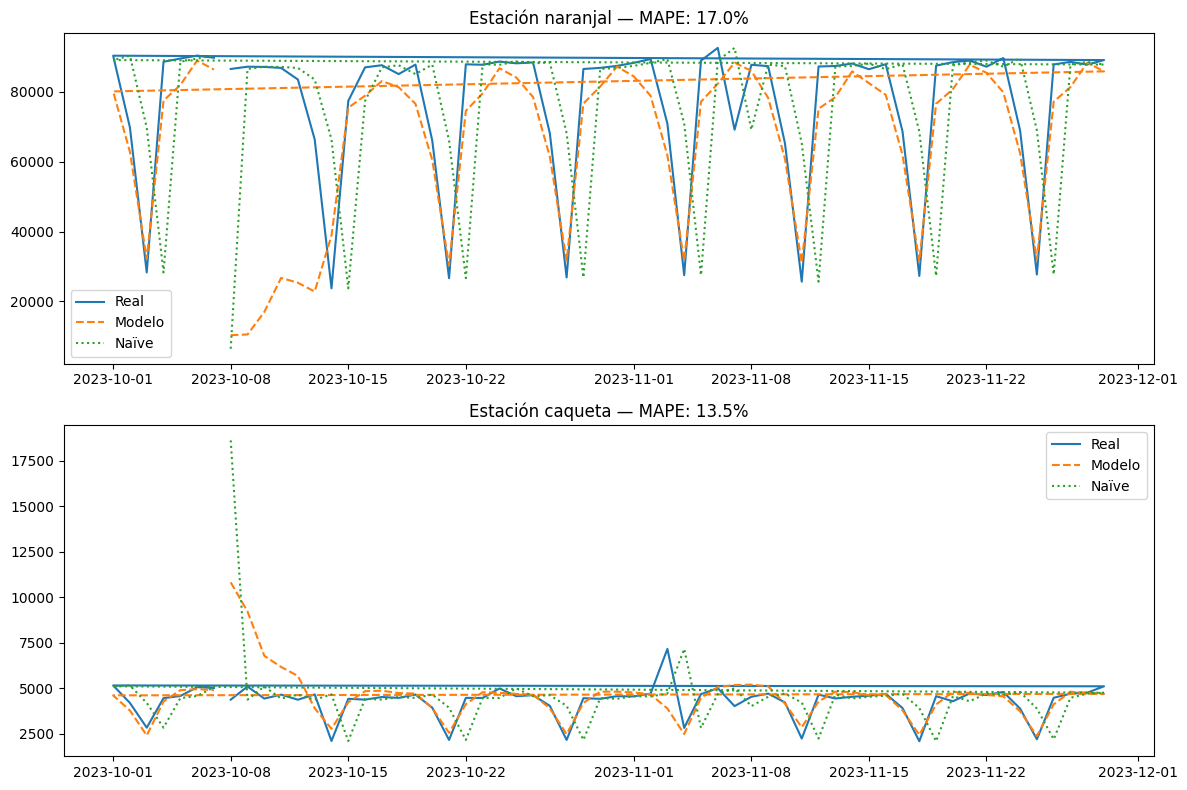

In [ ]:
# ================================
# 9) VALIDACIÓN POR ESTACIÓN (CORREGIDO)
# ================================
# 1) Alinea fechas
fechas_alineadas = fechas_test.iloc[n_lags:].reset_index(drop=True)

# 2) Construye el DataFrame de diagnóstico
dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
dfw['fecha']   = fechas_alineadas
dfw['y_true']  = y_true_g   # o y_true_l / y_true_r según el modelo
dfw['y_pred']  = y_pred_g   # o y_pred_l / y_pred_r
dfw['y_naive'] = dfw['y_true'].shift(1).bfill()

# 3) Recupera el station_id y mapea al nombre
#    test_sid es tu array de station_id completo
dfw['station_id'] = test_sid[n_lags:]
inv_station_ids  = {v:k for k,v in station_ids.items()}
dfw['estacion_rec'] = dfw['station_id'].map(inv_station_ids)

# 4) Calcula métricas por estación
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
metrics = []
for est, grp in dfw.groupby('estacion_rec'):
    yt = grp['y_true'].values
    yp = grp['y_pred'].values
    yn = grp['y_naive'].values

    mae_model  = mean_absolute_error(yt, yp)
    rmse_model = np.sqrt(mean_squared_error(yt, yp))
    mape_model = mean_absolute_percentage_error(yt, yp) * 100

    mae_naive  = mean_absolute_error(yt, yn)
    rmse_naive = np.sqrt(mean_squared_error(yt, yn))
    mejora_mae = (mae_naive - mae_model) / mae_naive * 100

    metrics.append({
        'estacion':       est,
        'MAE_model':      mae_model,
        'RMSE_model':     rmse_model,
        'MAPE_model (%)': mape_model,
        'MAE_naive':      mae_naive,
        'RMSE_naive':     rmse_naive,
        'Mejora MAE (%)': mejora_mae
    })

metrics_df = pd.DataFrame(metrics).sort_values('Mejora MAE (%)', ascending=False)
print(metrics_df)

# 5) Gráfica ejemplo
import matplotlib.pyplot as plt
estaciones_a_mostrar = ['naranjal','caqueta']
plt.figure(figsize=(12,4*len(estaciones_a_mostrar)))
for i, est in enumerate(estaciones_a_mostrar,1):
    sub = dfw[dfw['estacion_rec']==est]
    plt.subplot(len(estaciones_a_mostrar),1,i)
    plt.plot(sub['fecha'], sub['y_true'],  label='Real')
    plt.plot(sub['fecha'], sub['y_pred'],  '--', label='Modelo')
    plt.plot(sub['fecha'], sub['y_naive'], ':',  label='Naïve')
    plt.title(f'Estación {est} — MAPE: {(mean_absolute_percentage_error(sub.y_true, sub.y_pred)*100):.1f}%')
    plt.legend()
plt.tight_layout()
plt.show()


In [1]:
# ================================
# 0) Instala KerasTuner (si no está ya instalado)
# ================================
#%pip install --quiet keras-tuner

# ================================
# 1) IMPORTS
# ================================
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ================================
# 2) CARGA Y PREPROCESAMIENTO (igual que antes)
# ================================
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# Variables cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2*np.pi*df['mes']/12)
df['mes_cos']    = np.cos(2*np.pi*df['mes']/12)
df['dsem_sin']   = np.sin(2*np.pi*df['dia_semana']/7)
df['dsem_cos']   = np.cos(2*np.pi*df['dia_semana']/7)

# Imputa validaciones <100
mask_ok = df['validaciones'] >= 100
prom    = (
    df[mask_ok]
    .groupby(['estacion','dia_semana'])['validaciones']
    .mean()
    .rename('prom_est')
    .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# Target t+1
df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

# Codifica estación y log-transform
station_ids     = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

# Split temporal y escalado
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

feat_cols   = ['validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos','es_finde','feriado','vacaciones_escolares','eventos']
# Automáticamente detecta columnas numéricas para features:
#exclude_cols = ['fecha', 'estacion', 'validaciones', 'target', 'log_target', 'log_tgt_sc', 'station_id']
#feat_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.int64, np.int32, np.float64]]
print("Columnas usadas automáticamente:", feat_cols)

Saving Datos_final.csv to Datos_final (3).csv
Columnas usadas automáticamente: ['validaciones_clean', 'mes_sin', 'mes_cos', 'dsem_sin', 'dsem_cos', 'es_finde', 'feriado', 'vacaciones_escolares', 'eventos']


In [2]:

scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

for d in (train_df, val_df, test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

fechas_test = test_df['fecha'].reset_index(drop=True)

# Prepara arrays
n_lags     = 7
batch_size = 16

train_x   = train_df[feat_cols].values.astype('float32')
train_y   = train_df['log_tgt_sc'].values.astype('float32')
train_sid = train_df['station_id'].values.astype('int32')

val_x   = val_df[feat_cols].values.astype('float32')
val_y   = val_df['log_tgt_sc'].values.astype('float32')
val_sid = val_df['station_id'].values.astype('int32')

test_x   = test_df[feat_cols].values.astype('float32')
test_y   = test_df['log_tgt_sc'].values.astype('float32')
test_sid = test_df['station_id'].values.astype('int32')

# Generador
def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    sig = (
        tf.TensorSpec((n_lags,len(feat_cols)), tf.float32),
        tf.TensorSpec((),                tf.int32),
        tf.TensorSpec((),                tf.float32)
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=sig)
    if shuffle: ds = ds.shuffle(10_000)
    ds = ds.map(lambda x,s,y: ((x,s), y), tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(val_x,   val_sid,   val_y, shuffle=False)

# ================================
# 3) DEFINIR MODEL BUILDER PARA TUNER
# ================================
def model_builder(hp):
    cell_type = hp.Choice("cell_type", ["LSTM", "GRU", "RNN"])
    units1    = hp.Int("units1", 32, 128, step=32)
    return_seq= hp.Boolean("return_seq")
    units2    = hp.Int("units2", 16, 64, step=16) if return_seq else None
    dropout   = hp.Float("dropout", 0.0, 0.5, step=0.1)
    emb_dim   = hp.Int("emb_dim", 4, 16, step=4)
    lr        = hp.Float("lr", 1e-4, 1e-2, sampling="log")

    # Entradas
    seq_in  = Input((n_lags,len(feat_cols)))
    stat_in = Input((), dtype="int32")
    emb     = Embedding(len(station_ids), emb_dim)(stat_in)
    emb     = Flatten()(emb)

    # Capa recurrente 1
    if cell_type=="LSTM":
        x = LSTM(units1, return_sequences=return_seq)(seq_in)
    elif cell_type=="GRU":
        x = GRU(units1, return_sequences=return_seq)(seq_in)
    else:
        x = SimpleRNN(units1, return_sequences=return_seq)(seq_in)

    # Capa recurrente 2 opcional
    if return_seq:
        if cell_type=="LSTM":
            x = LSTM(units2)(x)
        elif cell_type=="GRU":
            x = GRU(units2)(x)
        else:
            x = SimpleRNN(units2)(x)

    x = Concatenate()([x, emb])
    x = Dropout(dropout)(x)
    x = Dense(hp.Int("dense_units", 4, 32, step=4), activation="relu")(x)
    out = Dense(1)(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
    )
    return model

# ================================
# 4) CONFIGURAR Y EJECUTAR TUNER
# ================================
tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_mape",
    max_trials=10,
    directory="tuner_logs",
    project_name="metro_tuning"
)

tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=[EarlyStopping("val_mape", patience=3)],
    verbose=1
)



<ipython-input-2-2d00b47cfcb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[feat_cols]    = scaler_feat.transform(d[feat_cols])
<ipython-input-2-2d00b47cfcb4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-2-2d00b47cfcb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Reloading Tuner from tuner_logs/metro_tuning/tuner0.json


In [3]:
# ================================
# 5) EXTRAER MEJORES HP Y REENTRENAR
# ================================
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Dataset de test
ds_test = make_dataset(test_x, test_sid, test_y, shuffle=False)

best_model.fit(
    ds_train.repeat(),
    validation_data=ds_val,
    epochs=50,
    steps_per_epoch=1000,
    callbacks=[EarlyStopping("val_mape", patience=7)],
    verbose=1
)

# ================================
# 6) EVALUAR EN TEST
# ================================
pred_log = best_model.predict(ds_test)
y_pred   = np.expm1(scaler_tgt.inverse_transform(pred_log).flatten())
y_true   = test_df['target'].values[n_lags:]

mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"BEST → MAE: {mae:.1f}, RMSE: {rmse:.1f}, MAPE: {mape:.1f}%")




Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - loss: 0.2810 - mape: 215.3887 - val_loss: 0.0740 - val_mape: 143.4184
Epoch 2/50
   8/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0852 - mape: 121.7328

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.1038 - mape: 121.7727 - val_loss: 0.0574 - val_mape: 143.8926
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.1020 - mape: 162.9154 - val_loss: 0.0691 - val_mape: 151.5892
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0841 - mape: 131.7423 - val_loss: 0.0792 - val_mape: 142.7479
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0789 - mape: 95.9447 - val_loss: 0.0956 - val_mape: 190.3200
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.0729 - mape: 113.2862 - val_loss: 0.0698 - val_mape: 149.1262
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0655 - mape: 103.9342 - val_loss: 0.0579 - val_mape: 124.6738
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0703 - mape: 132.7331 - val_loss: 0.1093 - val_mape: 155.6011
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0558 - mape: 82.1802 - val_loss: 0.0595 - val_mape

              estacion     MAE_model    RMSE_model  MAPE_model (%)  \
27            pacifico    535.181934   1392.603641       36.109598   
12          el milagro    180.683426    228.976980       10.296460   
0            2 de mayo    518.752624    718.626579       18.201005   
37                 uni    981.270464   1416.360662       12.640672   
28  parque del trabajo    164.199113    203.940507       11.746686   
1          28 de julio    372.066396    479.395938       11.832418   
19       independencia    552.387284    817.127903       13.544974   
20           izaguirre   1138.267045   1829.334400       12.321827   
5            benavides   1252.800989   2181.290722       12.958101   
32       ricardo palma    925.211224   1362.417016       10.500361   
31      ramon castilla    750.616868   1187.577421       81.182326   
10             colmena    849.157866   1113.144249       23.651263   
29     plaza de flores    838.727595   1362.283373       16.573138   
7               cana

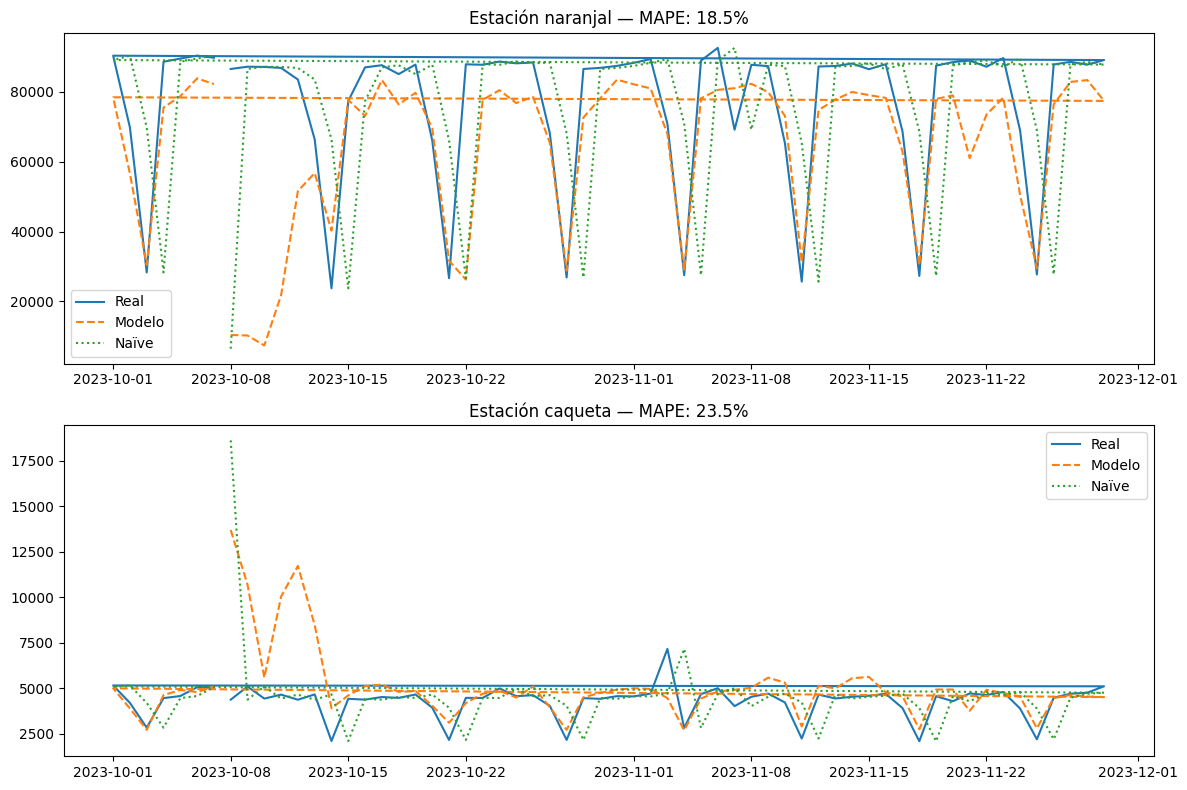

In [4]:


# ================================
# 7) VALIDACIÓN POR ESTACIÓN
# ================================
# 7.1) Alinea fechas de test (igual que antes)
fechas_alineadas = fechas_test.iloc[n_lags:].reset_index(drop=True)

# 7.2) Construye df de diagnóstico
dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
dfw['fecha']   = fechas_alineadas
dfw['y_true']  = y_true
dfw['y_pred']  = y_pred
dfw['y_naive'] = dfw['y_true'].shift(1).bfill()

# 7.3) Recupera el station_id y mapea al nombre
dfw['station_id']   = test_sid[n_lags:]
inv_station_ids     = {v:k for k,v in station_ids.items()}
dfw['estacion_rec'] = dfw['station_id'].map(inv_station_ids)

# 7.4) Calcula métricas por estación
metrics = []
for est, grp in dfw.groupby('estacion_rec'):
    yt, yp, yn = grp['y_true'].values, grp['y_pred'].values, grp['y_naive'].values

    mae_model  = mean_absolute_error(yt, yp)
    rmse_model = np.sqrt(mean_squared_error(yt, yp))
    mape_model = mean_absolute_percentage_error(yt, yp) * 100

    mae_naive  = mean_absolute_error(yt, yn)
    rmse_naive = np.sqrt(mean_squared_error(yt, yn))
    mejora_mae = (mae_naive - mae_model) / mae_naive * 100

    metrics.append({
        'estacion':       est,
        'MAE_model':      mae_model,
        'RMSE_model':     rmse_model,
        'MAPE_model (%)': mape_model,
        'MAE_naive':      mae_naive,
        'RMSE_naive':     rmse_naive,
        'Mejora MAE (%)': mejora_mae
    })

metrics_df = pd.DataFrame(metrics).sort_values('Mejora MAE (%)', ascending=False)
print(metrics_df)

# 7.5) Gráfica de ejemplo
plt.figure(figsize=(12,4*2))
for i, est in enumerate(['naranjal','caqueta'], 1):
    sub = dfw[dfw['estacion_rec']==est]
    plt.subplot(2,1,i)
    plt.plot(sub['fecha'], sub['y_true'],  label='Real')
    plt.plot(sub['fecha'], sub['y_pred'],  '--', label='Modelo')
    plt.plot(sub['fecha'], sub['y_naive'], ':',  label='Naïve')
    mape_loc = mean_absolute_percentage_error(sub.y_true, sub.y_pred)*100
    plt.title(f'Estación {est} — MAPE: {mape_loc:.1f}%')
    plt.legend()
plt.tight_layout()
plt.show()


# Prueba 5

In [2]:
# ================================
# 0) (Opcional) Instala Keras Tuner
# ================================
!pip install --quiet keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [3]:


# ================================
# 1) IMPORTS
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# ================================
# 2) CARGA Y PREPARACIÓN INICIAL
# ================================
# 2.1) Subida interactiva y lectura
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

# 2.2) Normaliza nombres y convierte la fecha
df.columns   = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['fecha']  = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# ================================
# 3) GENERACIÓN DE FEATURES
# ================================
# 3.1) Variables temporales cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2*np.pi * df['mes'] / 12)
df['mes_cos']    = np.cos(2*np.pi * df['mes'] / 12)
df['dsem_sin']   = np.sin(2*np.pi * df['dia_semana'] / 7)
df['dsem_cos']   = np.cos(2*np.pi * df['dia_semana'] / 7)

# 3.2) Comprobación de columnas binarias preexistentes
required_bins = ['es_finde','feriado','vacaciones_escolares','eventos']
missing = [c for c in required_bins if c not in df.columns]
if missing:
    raise ValueError(f"Faltan estas columnas binarias en el CSV: {missing}")
# (Suponemos que 'es_finde','feriado','vacaciones_escolares','eventos' ya existen)

# ================================
# 4) LIMPIEZA DE VALIDACIONES
# ================================
mask_ok = df['validaciones'] >= 100
prom = (
    df[mask_ok]
      .groupby(['estacion','dia_semana'])['validaciones']
      .mean()
      .rename('prom_est')
      .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# ================================
# 5) TARGET t+1 y TRANSFORMACIÓN
# ================================
df = df.sort_values(['estacion','fecha'])
df['target']     = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)
df['log_target'] = np.log1p(df['target'])

# ================================
# 6) CODIFICACIÓN DE ESTACIÓN
# ================================
station_ids      = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)

# ================================
# 7) SPLIT TEMPORAL
# ================================
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

# ================================
# 8) SELECCIÓN Y ESCALADO DE FEATURES y TARGET
# ================================
feat_cols = [
    'validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos',
    'es_finde','feriado','vacaciones_escolares','eventos'
]

# 8.1) Ajuste de scalers sólo con train
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

# 8.2) Transformación consistente en train/val/test
for d in (train_df, val_df, test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# Guarda las fechas de test para gráficas posteriores
fechas_test = test_df['fecha'].reset_index(drop=True)

# ================================
# 9) PREPARA TF DATASETS
# ================================
n_lags, batch_size = 7, 16

def to_array(df_):
    return (
        df_[feat_cols].values.astype('float32'),
        df_['station_id'].values.astype('int32'),
        df_['log_tgt_sc'].values.astype('float32'),
    )

train_x, train_sid, train_y = to_array(train_df)
val_x,   val_sid,   val_y   = to_array(val_df)
test_x,  test_sid,  test_y  = to_array(test_df)

def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    sig = (
        tf.TensorSpec((n_lags, len(feat_cols)), tf.float32),
        tf.TensorSpec((),                tf.int32),
        tf.TensorSpec((),                tf.float32)
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=sig)
    if shuffle:
        ds = ds.shuffle(10_000)
    ds = ds.map(lambda x,s,y: ((x,s), y), tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(val_x,   val_sid,   val_y, shuffle=False)
ds_test  = make_dataset(test_x,  test_sid,  test_y, shuffle=False)


Saving Datos_final.csv to Datos_final.csv


<ipython-input-3-0c8834855d06>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[feat_cols]    = scaler_feat.transform(d[feat_cols])
<ipython-input-3-0c8834855d06>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-3-0c8834855d06>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [4]:

# ================================
#10) DEFINICIÓN DEL MODEL BUILDER
# ================================
def model_builder(hp):
    cell_type  = hp.Choice("cell_type", ["LSTM","GRU","RNN"])
    units1     = hp.Int("units1", 32,128,step=32)
    return_seq = hp.Boolean("return_seq")
    units2     = hp.Int("units2", 16,64, step=16) if return_seq else None
    dropout    = hp.Float("dropout",0.0,0.5,step=0.1)
    emb_dim    = hp.Int("emb_dim",4,16,step=4)
    lr         = hp.Float("lr",1e-4,1e-2,sampling="log")

    seq_in  = Input((n_lags, len(feat_cols)))
    stat_in = Input((), dtype="int32")
    emb     = Embedding(len(station_ids), emb_dim)(stat_in)
    emb     = Flatten()(emb)

    # 1ª capa recurrente
    if cell_type=="LSTM":
        x = LSTM(units1, return_sequences=return_seq)(seq_in)
    elif cell_type=="GRU":
        x = GRU(units1, return_sequences=return_seq)(seq_in)
    else:
        x = SimpleRNN(units1, return_sequences=return_seq)(seq_in)

    # 2ª capa recurrente opcional
    if return_seq:
        if cell_type=="LSTM":
            x = LSTM(units2)(x)
        elif cell_type=="GRU":
            x = GRU(units2)(x)
        else:
            x = SimpleRNN(units2)(x)

    x   = Concatenate()([x, emb])
    x   = Dropout(dropout)(x)
    x   = Dense(hp.Int("dense_units",4,32,step=4), activation="relu")(x)
    out = Dense(1)(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
    )
    return model

# ================================
#11) BÚSQUEDA DE HIPERPARÁMETROS
# ================================
tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_mape",
    max_trials=10,
    directory="tuner_logs",
    project_name="metro_tuning"
)
tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=[EarlyStopping("val_mape", patience=3)],
    verbose=1
)

# ================================
#12) REENTRENAR CON LOS MEJORES HP
# ================================
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

best_model.fit(
    ds_train.repeat(),
    validation_data=ds_val,
    epochs=50,
    steps_per_epoch=1000,
    callbacks=[EarlyStopping("val_mape", patience=7)],
    verbose=1
)



Trial 10 Complete [00h 02m 36s]
val_mape: 106.95074462890625

Best val_mape So Far: 93.36199188232422
Total elapsed time: 00h 51m 22s
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.3071 - mape: 212.4371 - val_loss: 0.1320 - val_mape: 185.7097
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.1029 - mape: 109.1470 - val_loss: 0.0520 - val_mape: 106.0086
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.0958 - mape: 124.8432 - val_loss: 0.0543 - val_mape: 118.2804
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 0.0802 - mape: 99.0969 - val_loss: 0.0841 - val_mape: 175.9964
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0823 - mape: 85.3492 - val_loss: 0.0814 - val_mape: 166.2974
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0723 - mape: 95.5883 - val_loss: 0.0736 - val_mape: 155.1319
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0644 - mape: 111.2965 - val_loss: 0

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
TEST → MAE:  1440.07
       RMSE: 4482.39
       MAPE: 20.54%
              estacion           MAE   MAPE (%)  Mejora MAE (%)
37                 Uni    910.704717  13.675170       60.732870
8    Canaval y Moreyra   1867.014004  22.416349       60.547046
21        Javier Prado   1617.505568  13.912091       60.518541
29     Plaza de Flores    659.451592  14.706281       58.766460
0            2 de Mayo    515.194256  18.155136       58.680571
28  Parque del Trabajo    153.387819  12.114084       57.400358
32       Ricardo Palma    828.486521  10.502266       56.772664
20           Izaguirre   1050.342777  13.244307       56.537844
5            Benavides   1169.069730  14.160552       55.327933
7               Canada   1223.684686  11.890788       53.139522
10             Colmena    789.108456  26.180210       52.462700
4                Balta    329.042483   8.186861       51.969648
19       Independencia    575.901456  15.321092       51.523753
2

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


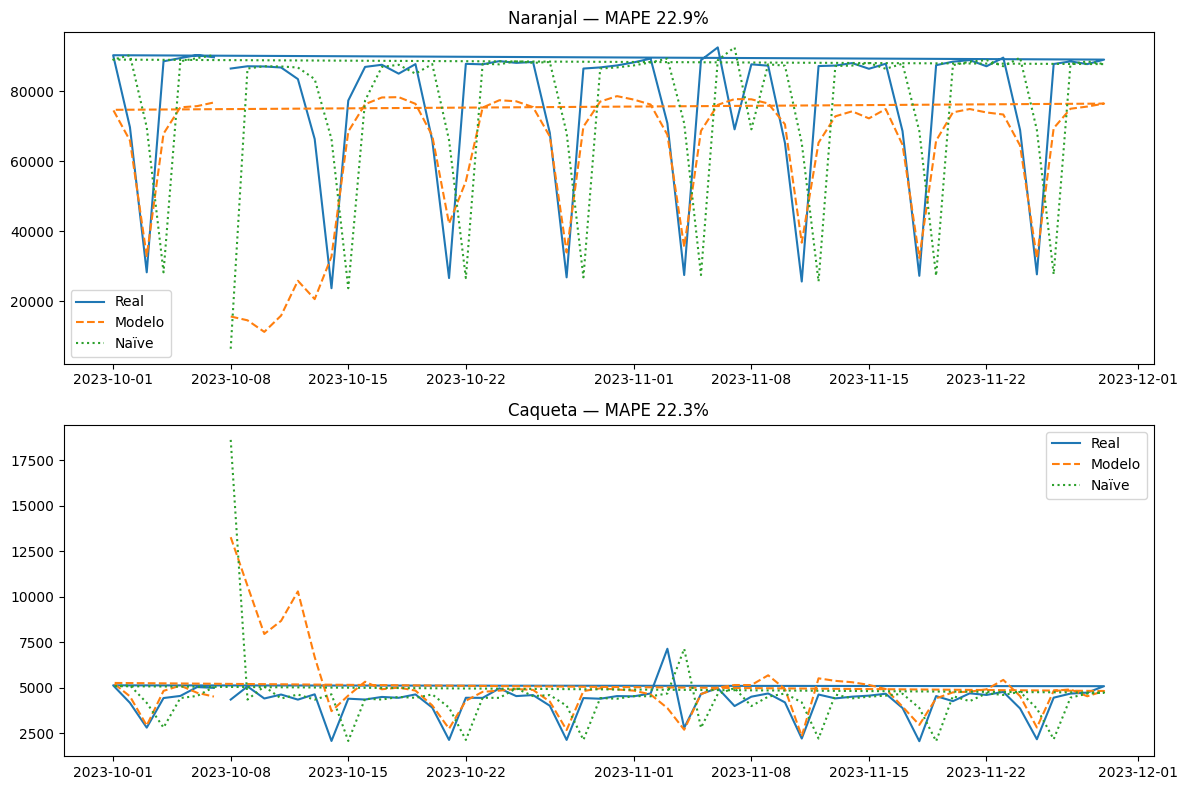

In [8]:
# ================================
#13) EVALUACIÓN FINAL EN TEST
# ================================
# 13.1) Predicción en escala log‑estandarizada
pred_log     = best_model.predict(ds_test)

# 13.2) Inversión de StandardScaler + log1p
pred_log_inv = scaler_tgt.inverse_transform(pred_log)
y_pred       = np.expm1(pred_log_inv.flatten())

# 13.3) Alinea los verdaderos (se ignoran los primeros n_lags)
y_true       = test_df['target'].iloc[n_lags:].values
assert len(y_true)==len(y_pred), "Desajuste en longitudes de y_true/y_pred"

# 13.4) Cálculo de métricas en escala original
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"TEST → MAE:  {mae:.2f}")
print(f"       RMSE: {rmse:.2f}")
print(f"       MAPE: {mape:.2f}%")

# ================================
#14) VALIDACIÓN POR ESTACIÓN (opcional)
# ================================
# Construye df de diagnóstico
dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
dfw['fecha']   = fechas_test.iloc[n_lags:].reset_index(drop=True)
dfw['y_true']  = y_true
dfw['y_pred']  = y_pred
dfw['y_naive'] = dfw['y_true'].shift(1).bfill()
dfw['estacion']= dfw['station_id'].map({v:k for k,v in station_ids.items()})

# Calcula y muestra métricas por estación
metrics = []
for est, grp in dfw.groupby('estacion'):
    yt, yp, yn = grp['y_true'], grp['y_pred'], grp['y_naive']
    mae_m = mean_absolute_error(yt, yp)
    mape_m= mean_absolute_percentage_error(yt, yp)*100
    mae_n = mean_absolute_error(yt, yn)
    mejora = (mae_n - mae_m)/mae_n*100
    metrics.append((est, mae_m, mape_m, mejora))

metrics_df = pd.DataFrame(metrics, columns=['estacion','MAE','MAPE (%)','Mejora MAE (%)'])\
               .sort_values('Mejora MAE (%)', ascending=False)
print(metrics_df)

# Gráfica de ejemplo de dos estaciones
plt.figure(figsize=(12,8))
for i, est in enumerate(['Naranjal','Caqueta'], 1):
    sub = dfw[dfw['estacion']==est]
    if sub.empty:
        print(f">>> Atención: no hay datos de test para la estación '{est}', la salto.")
        continue
    plt.subplot(2,1,i)
    plt.plot(sub['fecha'], sub['y_true'],  label='Real')
    plt.plot(sub['fecha'], sub['y_pred'],  '--', label='Modelo')
    plt.plot(sub['fecha'], sub['y_naive'], ':',  label='Naïve')
    plt.title(f"{est.title()} — MAPE {mean_absolute_percentage_error(sub.y_true, sub.y_pred)*100:.1f}%")
    plt.legend()
plt.tight_layout()
plt.show()


# Prueba 6

In [1]:
!pip install --quiet keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [2]:
# ================================
# 1) IMPORTS & SEMILLAS
# ================================
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics     import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras    import Model, Input
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks    import EarlyStopping

import keras_tuner as kt
import os

# Fijar semillas para reproducibilidad  [MODIFICADO]
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


# ================================
# 2) CARGA Y PREPARACIÓN INICIAL
# ================================
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

df.columns   = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['fecha']  = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)


# ================================
# 3) GENERACIÓN DE FEATURES
# ================================
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2*np.pi * df['mes'] / 12)
df['mes_cos']    = np.cos(2*np.pi * df['mes'] / 12)
df['dsem_sin']   = np.sin(2*np.pi * df['dia_semana'] / 7)
df['dsem_cos']   = np.cos(2*np.pi * df['dia_semana'] / 7)

required_bins = ['es_finde','feriado','vacaciones_escolares','eventos']
missing = [c for c in required_bins if c not in df.columns]
if missing:
    raise ValueError(f"Faltan estas columnas binarias en el CSV: {missing}")


# ================================
# 4) LIMPIEZA DE VALIDACIONES
# ================================
mask_ok = df['validaciones'] >= 100
prom = (
    df[mask_ok]
      .groupby(['estacion','dia_semana'])['validaciones']
      .mean()
      .rename('prom_est')
      .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# ================================
# 4.b) LOG‑TRANSFORM DE LA FEATURE principal  [MODIFICADO]
# ================================
df['valid_clean_log'] = np.log1p(df['validaciones_clean'])


# ================================
# 5) TARGET t+1 y TRANSFORMACIÓN
# ================================
df = df.sort_values(['estacion','fecha'])
df['target']     = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)
df['log_target'] = np.log1p(df['target'])


# ================================
# 6) CODIFICACIÓN DE ESTACIÓN
# ================================
station_ids      = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)


# ================================
# 7) SPLIT TEMPORAL
# ================================
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']


# ================================
# 8) SELECCIÓN Y ESCALADO DE FEATURES y TARGET  [MODIFICADO]
# ================================
feat_cols = [
    'valid_clean_log',    # cambio a la versión logarítmica
    'mes_sin','mes_cos','dsem_sin','dsem_cos',
    'es_finde','feriado','vacaciones_escolares','eventos'
]

# 8.1 Ajuste de scalers solo con train
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

# 8.2 Transformación consistente en train/val/test
for d in (train_df, val_df, test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# Guarda las fechas de test para gráficas posteriores
fechas_test = test_df['fecha'].reset_index(drop=True)


# ================================
# 9) PREPARA TF DATASETS
# ================================
n_lags, batch_size = 7, 16

def to_array(df_):
    return (
        df_[feat_cols].values.astype('float32'),
        df_['station_id'].values.astype('int32'),
        df_['log_tgt_sc'].values.astype('float32'),
    )

train_x, train_sid, train_y = to_array(train_df)
val_x,   val_sid,   val_y   = to_array(val_df)
test_x,  test_sid,  test_y  = to_array(test_df)

def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    sig = (
        tf.TensorSpec((n_lags, len(feat_cols)), tf.float32),
        tf.TensorSpec((),                tf.int32),
        tf.TensorSpec((),                tf.float32)
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=sig)
    if shuffle:
        ds = ds.shuffle(10_000)
    ds = ds.map(lambda x,s,y: ((x,s), y), tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(val_x,   val_sid,   val_y, shuffle=False)
ds_test  = make_dataset(test_x,  test_sid,  test_y, shuffle=False)


Saving Datos_final.csv to Datos_final.csv


<ipython-input-2-f89d3d84ad44>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[feat_cols]    = scaler_feat.transform(d[feat_cols])
<ipython-input-2-f89d3d84ad44>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-2-f89d3d84ad44>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [3]:

# ================================
#10) DEFINICIÓN DEL MODEL BUILDER
# ================================
def model_builder(hp):
    cell_type  = hp.Choice("cell_type", ["LSTM","GRU","RNN"])
    units1     = hp.Int("units1", 32,128,step=32)
    return_seq = hp.Boolean("return_seq")
    units2     = hp.Int("units2", 16,64, step=16) if return_seq else None
    dropout    = hp.Float("dropout",0.0,0.5,step=0.1)
    emb_dim    = hp.Int("emb_dim",4,16,step=4)
    lr         = hp.Float("lr",1e-4,1e-2,sampling="log")

    seq_in  = Input((n_lags, len(feat_cols)))
    stat_in = Input((), dtype="int32")
    emb     = Embedding(len(station_ids), emb_dim)(stat_in)
    emb     = Flatten()(emb)

    # 1ª capa recurrente
    if cell_type=="LSTM":
        x = LSTM(units1, return_sequences=return_seq)(seq_in)
    elif cell_type=="GRU":
        x = GRU(units1, return_sequences=return_seq)(seq_in)
    else:
        x = SimpleRNN(units1, return_sequences=return_seq)(seq_in)

    # 2ª capa recurrente opcional
    if return_seq:
        if cell_type=="LSTM":
            x = LSTM(units2)(x)
        elif cell_type=="GRU":
            x = GRU(units2)(x)
        else:
            x = SimpleRNN(units2)(x)

    x   = Concatenate()([x, emb])
    x   = Dropout(dropout)(x)
    x   = Dense(hp.Int("dense_units",4,32,step=4), activation="relu")(x)
    out = Dense(1)(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
    )
    return model

# ================================
#11) BÚSQUEDA DE HIPERPARÁMETROS
# ================================
tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_mape",
    max_trials=10,
    directory="tuner_logs",
    project_name="metro_tuning"
)
tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=[EarlyStopping("val_mape", patience=3)],
    verbose=1
)

# ================================
#12) REENTRENAR CON LOS MEJORES HP
# ================================
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

best_model.fit(
    ds_train.repeat(),
    validation_data=ds_val,
    epochs=50,
    steps_per_epoch=1000,
    callbacks=[EarlyStopping("val_mape", patience=7)],
    verbose=1
)



Trial 10 Complete [00h 08m 58s]
val_mape: 82.26856994628906

Best val_mape So Far: 82.26856994628906
Total elapsed time: 00h 52m 14s
Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.5923 - mape: 169.3112 - val_loss: 0.0783 - val_mape: 122.3075
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.1589 - mape: 140.8970 - val_loss: 0.0853 - val_mape: 126.7117
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 0.1357 - mape: 148.7371 - val_loss: 0.0627 - val_mape: 99.0037
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.1161 - mape: 141.1353 - val_loss: 0.0587 - val_mape: 93.8003
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.1264 - mape: 112.5630 - val_loss: 0.0602 - val_mape: 118.6926
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - loss: 0.1056 - mape: 115.6279 - val_loss: 0.0558 - val_mape: 102.2553
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.1120 - mape: 103.2157 - val_loss: 0

143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
TEST → MAE:  1884.62
       RMSE: 5460.02
       MAPE: 22.76%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


              estacion           MAE   MAPE (%)  Mejora MAE (%)
12          El Milagro    201.630799  10.948867       56.527331
1          28 de Julio    366.731203  11.585034       54.264402
0            2 de Mayo    580.896831  19.871616       53.411116
37                 Uni   1184.714133  14.990723       48.918323
10             Colmena    858.248162  21.257234       48.297601
19       Independencia    640.772825  15.823021       46.063234
28  Parque del Trabajo    194.447974  13.233224       45.996924
22   Jiron de la Union   1321.700134  21.098548       45.356828
11        Domingo Orue    413.463373  16.840972       42.900520
29     Plaza de Flores    940.834644  18.693595       41.172417
5            Benavides   1543.025093  18.226909       41.038486
32       Ricardo Palma   1131.701048  13.046625       40.952061
20           Izaguirre   1441.643269  17.154336       40.346213
31      Ramon Castilla    947.766886  83.455509       37.015596
30              Quilca    502.563566  21

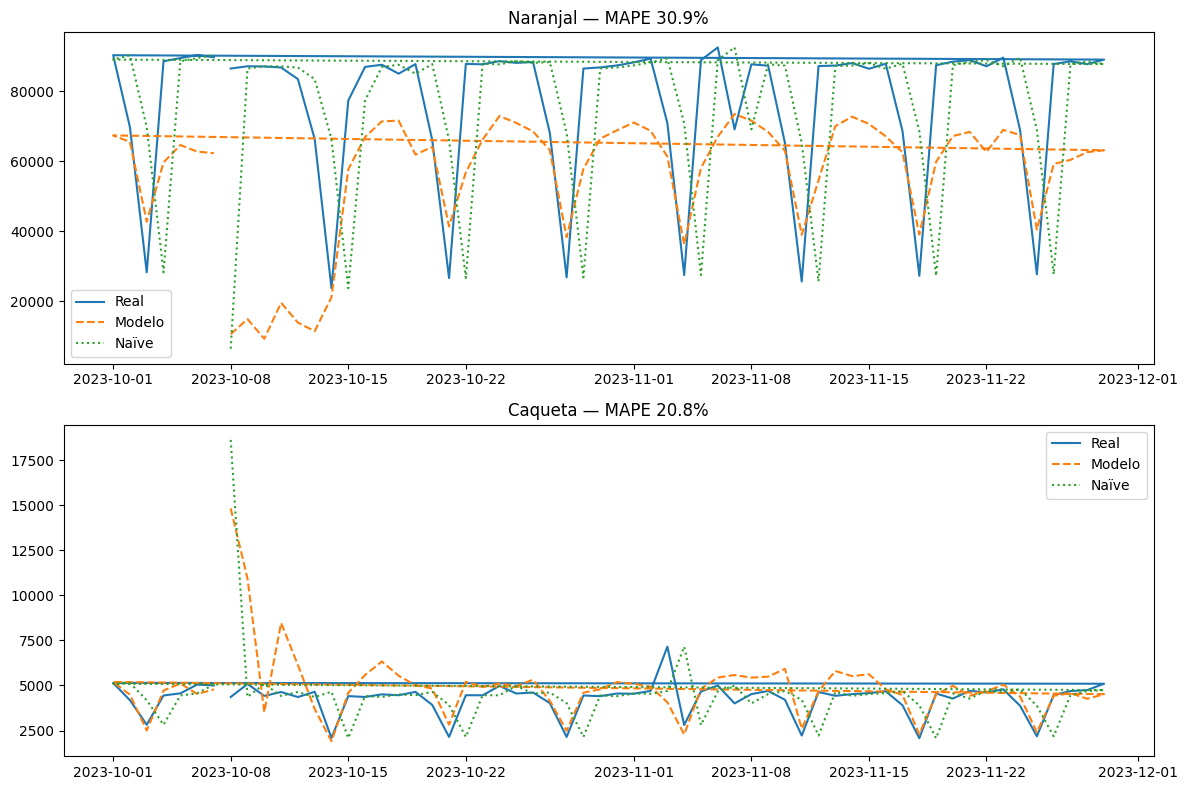

In [6]:
# ================================
#13) EVALUACIÓN FINAL EN TEST
# ================================
# 13.1) Predicción en escala log‑estandarizada
pred_log     = best_model.predict(ds_test)

# 13.2) Inversión de StandardScaler + log1p
pred_log_inv = scaler_tgt.inverse_transform(pred_log)
y_pred       = np.expm1(pred_log_inv.flatten())

# 13.3) Alinea los verdaderos (se ignoran los primeros n_lags)
y_true       = test_df['target'].iloc[n_lags:].values
assert len(y_true)==len(y_pred), "Desajuste en longitudes de y_true/y_pred"

# 13.4) Cálculo de métricas en escala original
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"TEST → MAE:  {mae:.2f}")
print(f"       RMSE: {rmse:.2f}")
print(f"       MAPE: {mape:.2f}%")

# ================================
#14) VALIDACIÓN POR ESTACIÓN (opcional)
# ================================
# Construye df de diagnóstico
dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
dfw['fecha']   = fechas_test.iloc[n_lags:].reset_index(drop=True)
dfw['y_true']  = y_true
dfw['y_pred']  = y_pred
dfw['y_naive'] = dfw['y_true'].shift(1).bfill()
dfw['estacion']= dfw['station_id'].map({v:k for k,v in station_ids.items()})

# Calcula y muestra métricas por estación
metrics = []
for est, grp in dfw.groupby('estacion'):
    yt, yp, yn = grp['y_true'], grp['y_pred'], grp['y_naive']
    mae_m = mean_absolute_error(yt, yp)
    mape_m= mean_absolute_percentage_error(yt, yp)*100
    mae_n = mean_absolute_error(yt, yn)
    mejora = (mae_n - mae_m)/mae_n*100
    metrics.append((est, mae_m, mape_m, mejora))

metrics_df = pd.DataFrame(metrics, columns=['estacion','MAE','MAPE (%)','Mejora MAE (%)'])\
               .sort_values('Mejora MAE (%)', ascending=False)
print(metrics_df)

# Gráfica de ejemplo de dos estaciones
plt.figure(figsize=(12,8))
for i, est in enumerate(['Naranjal','Caqueta'], 1):
    sub = dfw[dfw['estacion']==est]
    if sub.empty:
        print(f">>> Atención: no hay datos de test para la estación '{est}', la salto.")
        continue
    plt.subplot(2,1,i)
    plt.plot(sub['fecha'], sub['y_true'],  label='Real')
    plt.plot(sub['fecha'], sub['y_pred'],  '--', label='Modelo')
    plt.plot(sub['fecha'], sub['y_naive'], ':',  label='Naïve')
    plt.title(f"{est.title()} — MAPE {mean_absolute_percentage_error(sub.y_true, sub.y_pred)*100:.1f}%")
    plt.legend()
plt.tight_layout()
plt.show()


In [5]:
print(dfw['estacion'].unique())

['2 de Mayo' '28 de Julio' 'Angamos' 'Aramburu' 'Balta' 'Benavides'
 'Bulevar' 'Canada' 'Canaval y Moreyra' 'Caqueta' 'Colmena' 'Domingo Orue'
 'El Milagro' 'Escuela Militar' 'EspaÃ±a' 'Estacion Central'
 'Estadio Nacional' 'Estadio Union' 'Honorio Delgado' 'Independencia'
 'Izaguirre' 'Javier Prado' 'Jiron de la Union' 'Los jazmines' 'Matellini'
 'Mexico' 'Naranjal' 'Pacifico' 'Parque del Trabajo' 'Plaza de Flores'
 'Quilca' 'Ramon Castilla' 'Ricardo Palma' 'Rosario de Villa' 'Tacna'
 'Teran' 'Tomas Valle' 'Uni']


# Prueba 7

In [2]:
# ================================
# 0) Instalar dependencias en Colab
# ================================
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
# ================================
# 0) Instalar dependencias en Colab
# ================================
#!pip install -q keras-tuner

# ================================
# 1) Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# ================================
# 2) Métricas adicionales
# ================================
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def mase(y_true, y_pred, y_naive):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    return mae_model / (mae_naive + 1e-8)

# ================================
# 3) Carga de datos
# ================================
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

# ================================
# 4) Preprocesamiento
# ================================
df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# Variables cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos']    = np.cos(2 * np.pi * df['mes'] / 12)
df['dsem_sin']   = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['dsem_cos']   = np.cos(2 * np.pi * df['dia_semana'] / 7)

# Imputación de validaciones < 100
mask_ok = df['validaciones'] >= 100
prom    = (
    df[mask_ok]
    .groupby(['estacion','dia_semana'])['validaciones']
    .mean()
    .rename('prom_est')
    .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# Target t+1
df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

# Mapeo de estaciones y log-transform
station_ids      = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

# ================================
# 5) Split temporal y escalado
# ================================
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

feat_cols   = ['validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos']
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

# Evitar SettingWithCopyWarning
for d in (train_df, val_df, test_df):
    d.loc[:, feat_cols]   = scaler_feat.transform(d[feat_cols])
    d.loc[:, 'log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# Guardar fechas de test antes de drop lag
fechas_test = test_df['fecha'].reset_index(drop=True)

# ================================
# 6) Preparar arrays y datasets
# ================================
n_lags     = 7
batch_size = 16

def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    output_signature = (
        tf.TensorSpec((n_lags, len(feat_cols)), tf.float32),
        tf.TensorSpec((),                 tf.int32),
        tf.TensorSpec((),                 tf.float32),
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.map(lambda x_seq, sid, y: ((x_seq, sid), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_x, val_x, test_x = [d[feat_cols].values.astype('float32') for d in (train_df, val_df, test_df)]
train_y, val_y, test_y = [d['log_tgt_sc'].values.astype('float32') for d in (train_df, val_df, test_df)]
train_sid, val_sid, test_sid = [d['station_id'].values.astype('int32') for d in (train_df, val_df, test_df)]

ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(val_x,   val_sid,   val_y, shuffle=False)
ds_test  = make_dataset(test_x,  test_sid,  test_y, shuffle=False)

# ================================
# 7) Model builder para Keras Tuner
# ================================
def model_builder(hp):
    cell_type = hp.Choice("cell_type", ["LSTM","GRU","RNN"])
    u1        = hp.Int("units_1",    32, 128, step=32)
    u2        = hp.Int("units_2",    16, u1,  step=16)
    drop      = hp.Float("dropout",   0.0, 0.5, step=0.1)
    lr        = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    emb_dim   = hp.Int("emb_dim",     4, 16,  step=4)
    dense_u   = hp.Int("dense_units", 8, 32,  step=8)

    seq_in  = Input((n_lags,len(feat_cols)), name="seq_in")
    stat_in = Input((), dtype="int32", name="stat_in")
    x_emb   = Embedding(len(station_ids), emb_dim)(stat_in)
    x_emb   = Flatten()(x_emb)

    if cell_type=="LSTM":
        x = LSTM(u1, return_sequences=True)(seq_in)
        x = LSTM(u2)(x)
    elif cell_type=="GRU":
        x = GRU(u1, return_sequences=True)(seq_in)
        x = GRU(u2)(x)
    else:
        x = SimpleRNN(u1, return_sequences=True)(seq_in)
        x = SimpleRNN(u2)(x)

    x = Concatenate()([x, x_emb])
    x = Dropout(drop)(x)
    x = Dense(dense_u, activation="relu")(x)
    out = Dense(1, activation="linear")(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name="rmse"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
        ]
    )
    return model

# ================================
# 8) Hyperband Tuner
# ================================
tuner = kt.Hyperband(
    model_builder,
    objective="val_mape",
    max_epochs=30,
    factor=3,
    directory="tuner_dir",
    project_name="demanda_brt"
)
stop_early = EarlyStopping(monitor="val_mape", patience=5)

tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    callbacks=[stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials=3)

# ================================
# 9) Entrenar los 3 mejores
# ================================
models = []
for hp in best_hps:
    m = tuner.hypermodel.build(hp)
    m.fit(ds_train, validation_data=ds_val, epochs=30,
          callbacks=[stop_early], verbose=0)
    models.append((hp.get("cell_type"), m))



Trial 60 Complete [00h 02m 42s]
val_mape: 207.41404724121094

Best val_mape So Far: 75.51090240478516
Total elapsed time: 02h 09m 15s

Search: Running Trial #61

Value             |Best Value So Far |Hyperparameter
LSTM              |GRU               |cell_type
64                |96                |units_1
32                |16                |units_2
0.1               |0.2               |dropout
0.00085611        |0.0016124         |learning_rate
16                |8                 |emb_dim
32                |16                |dense_units
4                 |30                |tuner/epochs
0                 |10                |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/4
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 0.2807 - mape: 185.5719 - rmse: 0.5202 - val_loss: 0.1439 - val_mape: 260.4177 - val_rmse: 0.3793
Epoch 2/4
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1091 - mape: 1

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
  Modelo          MAE         RMSE   MAPE (%)  SMAPE (%)        R2      MASE
1    GRU  1555.177498  4497.821026  18.492151  17.723866  0.884789  0.673587
2    GRU  1381.414302  4414.804016  21.003591  15.519890  0.889002  0.598326
0    GRU  2498.653133  6855.103786  25.009373  22.729735  0.732380  1.082230
3  Naïve  2308.800218          NaN        NaN        NaN       NaN       NaN


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


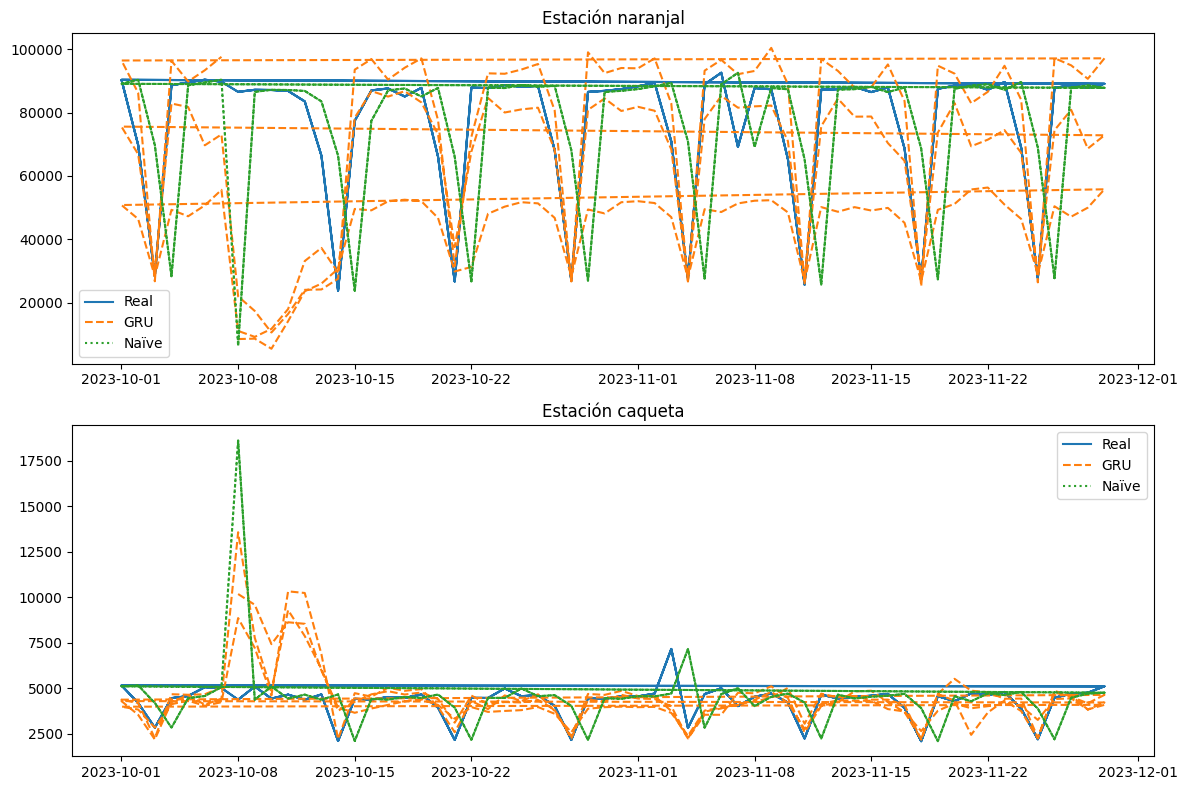

In [5]:
# ================================
# 10) Evaluación global y por estación
# ================================
results = []
diag_dfs = []

def eval_model(name, model):
    pred_log = model.predict(ds_test)
    y_pred   = np.expm1(scaler_tgt.inverse_transform(pred_log).flatten())
    y_true   = test_df['target'].values[n_lags:]
    y_naive  = pd.Series(y_true).shift(1).bfill().values

    results.append({
        "Modelo": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred)*100,
        "SMAPE (%)": smape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MASE": mase(y_true, y_pred, y_naive)
    })

    dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
    dfw["fecha"]   = fechas_test.iloc[n_lags:].reset_index(drop=True)
    dfw["y_true"]  = y_true
    dfw["y_pred"]  = y_pred
    dfw["y_naive"] = y_naive

    # Aquí viene la corrección: test_sid es un ndarray, así que primero lo convertimos a Series
    mapping = {v: k for k, v in station_ids.items()}
    serie_sid = pd.Series(test_sid[n_lags:])           # ndarray → Series
    dfw["estacion"] = serie_sid.map(mapping).values     # aplicamos map y recuperamos array

    dfw["Modelo"] = name
    diag_dfs.append(dfw)

# ahora ejecutas la evaluación
for name, mdl in models:
    eval_model(name, mdl)

# Baseline Naïve (igual que tenías)
ya = test_df['target'].values[n_lags:]
yn = pd.Series(ya).shift(1).bfill().values
results.append({
    "Modelo": "Naïve",
    "MAE": np.mean(np.abs(ya-yn)),
    "RMSE": np.nan,
    "MAPE (%)": np.nan,
    "SMAPE (%)": np.nan,
    "R2": np.nan,
    "MASE": np.nan
})

metrics_df = pd.DataFrame(results).sort_values("MAPE (%)")
print(metrics_df)

# y luego tus gráficos “Real vs Modelo vs Naïve”
plt.figure(figsize=(12, 4*2))
for i, est in enumerate(["naranjal","caqueta"], 1):
    sub = pd.concat(diag_dfs).query("estacion == @est")
    plt.subplot(2,1,i)
    plt.plot(sub["fecha"], sub["y_true"], label="Real")
    for mod in sub["Modelo"].unique():
        dfm = sub.query("Modelo == @mod")
        plt.plot(dfm["fecha"], dfm["y_pred"], "--", label=mod)
    plt.plot(sub["fecha"], sub["y_naive"], ":", label="Naïve")
    plt.title(f'Estación {est}')
    plt.legend()
plt.tight_layout()
plt.show()


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
  Modelo          MAE         RMSE   MAPE (%)  SMAPE (%)        R2      MASE
0    GRU  2051.174441  5887.004239  21.218260  18.626029  0.802631  0.888416
2    RNN  2488.196082  6117.759617  24.416632  22.767964  0.786855  1.077701
1   LSTM  3428.087390  8792.544263  30.465357  29.668617  0.559729  1.484792
3  Naïve  2308.800218          NaN        NaN        NaN       NaN       NaN


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


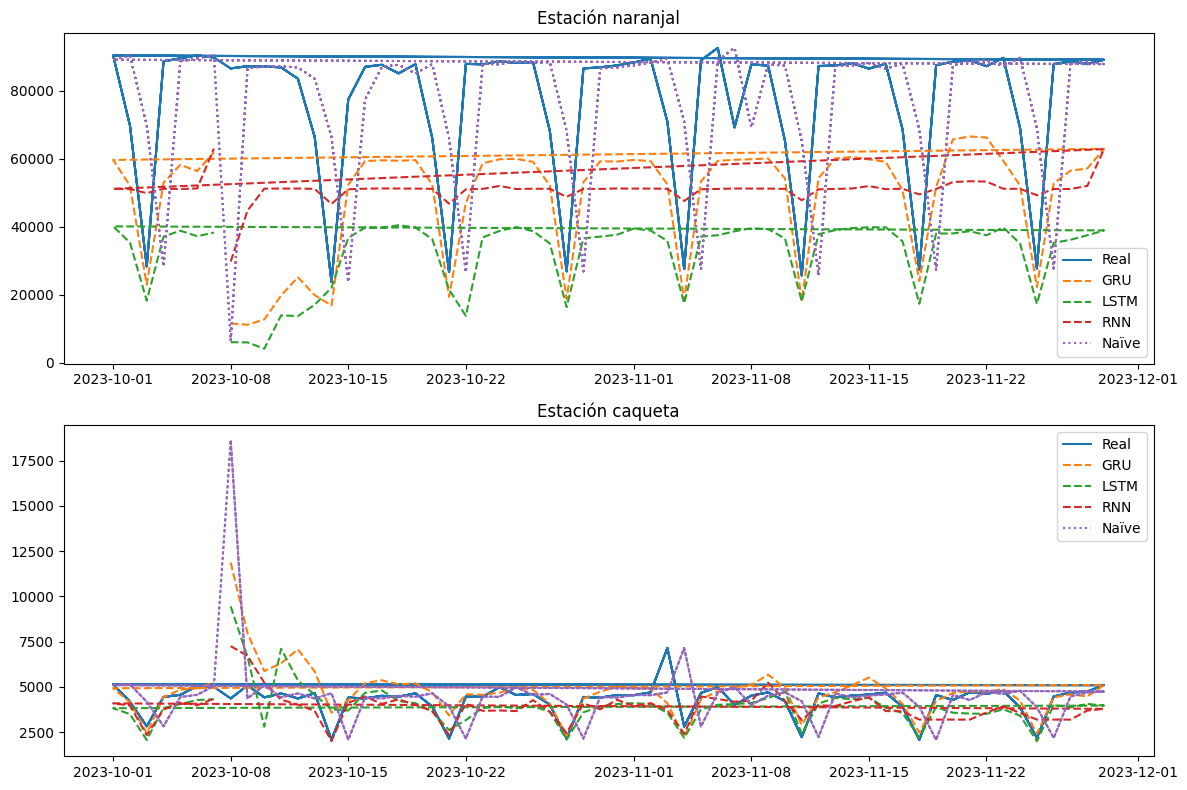

In [7]:
# ————————————————————————————————
# 9bis) Entrenar un LSTM y un RNN usando los mismos hiperparámetros que el mejor GRU
# ————————————————————————————————
# 1. Toma el primer conjunto de HP ganadores (que fue GRU)
best_hp = best_hps[0]

# 2. Construye y entrena el GRU (ya lo tienes, pero lo repetimos para ilustrar)
best_hp.values['cell_type'] = 'GRU'
model_gru = tuner.hypermodel.build(best_hp)
model_gru.fit(ds_train, validation_data=ds_val,
              epochs=30, callbacks=[stop_early], verbose=0)

# 3. Construye y entrena el LSTM
best_hp.values['cell_type'] = 'LSTM'
model_lstm = tuner.hypermodel.build(best_hp)
model_lstm.fit(ds_train, validation_data=ds_val,
               epochs=30, callbacks=[stop_early], verbose=0)

# 4. Construye y entrena el SimpleRNN
best_hp.values['cell_type'] = 'RNN'
model_rnn = tuner.hypermodel.build(best_hp)
model_rnn.fit(ds_train, validation_data=ds_val,
              epochs=30, callbacks=[stop_early], verbose=0)


# ————————————————————————————————
# 10) Evaluación global y por estación
# (ya con tu función corregida para station_id → estación)
# ————————————————————————————————
models = [
    ("GRU",   model_gru),
    ("LSTM",  model_lstm),
    ("RNN",   model_rnn),
]

# limpia resultados previos
results  = []
diag_dfs = []

for name, mdl in models:
    eval_model(name, mdl)

# añade Naïve como baseline
ya = test_df['target'].values[n_lags:]
yn = pd.Series(ya).shift(1).bfill().values
results.append({
    "Modelo": "Naïve",
    "MAE": np.mean(np.abs(ya-yn)),
    "RMSE": np.nan,
    "MAPE (%)": np.nan,
    "SMAPE (%)": np.nan,
    "R2": np.nan,
    "MASE": np.nan
})

metrics_df = pd.DataFrame(results).sort_values("MAPE (%)")
print(metrics_df)

# ————————————————————————————————
# 11) Gráficos “Real vs Modelo vs Naïve”
# ————————————————————————————————
plt.figure(figsize=(12, 8))
for i, est in enumerate(["naranjal", "caqueta"], 1):
    sub = pd.concat(diag_dfs).query("estacion == @est")
    plt.subplot(2,1,i)
    plt.plot(sub["fecha"], sub["y_true"], label="Real")
    for mod in sub["Modelo"].unique():
        dfm = sub.query("Modelo == @mod")
        plt.plot(dfm["fecha"], dfm["y_pred"], "--", label=mod)
    plt.plot(sub["fecha"], sub["y_naive"], ":", label="Naïve")
    plt.title(f'Estación {est}')
    plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ================================
# 0) Instalar dependencias en Colab
# ================================
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 655.9 kB/s eta 0:00:00


In [3]:
#NO EJECUTAR ES UN MODELO CON TODAS LAS VARIABLES

# ================================
# 1) Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# ================================
# 2) Métricas adicionales
# ================================
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) /
                   (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def mase(y_true, y_pred, y_naive):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    return mae_model / (mae_naive + 1e-8)

# ================================
# 3) Carga de datos
# ================================
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

# ================================
# 4) Preprocesamiento
# ================================
# Normalizar nombres y fechas
df.columns     = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha']    = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# Variables cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos']    = np.cos(2 * np.pi * df['mes'] / 12)
df['dsem_sin']   = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['dsem_cos']   = np.cos(2 * np.pi * df['dia_semana'] / 7)

# Imputación de validaciones < 100
mask_ok = df['validaciones'] >= 100
prom = (
    df[mask_ok]
    .groupby(['estacion','dia_semana'])['validaciones']
    .mean()
    .rename('prom_est')
    .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# Target t+1
df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

# Mapeo de estaciones y log-transform
station_ids      = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

# --- NUEVO: Mapear tipo de evento como entero ---
event_type_ids      = {e:i for i,e in enumerate(df['tipo_evento'].unique())}
df['event_type_id'] = df['tipo_evento'].map(event_type_ids)

# ================================
# 5) Split temporal y escalado
# ================================
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

# --- DYNAMIC FEATURES: incluyen flags de feriado, vacaciones, eventos ---
feat_cols = [
    'validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos',
    'feriado','vacaciones_escolares','vacaciones_universitarias',
    'es_finde','eventos'
]

scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

# Evitar SettingWithCopyWarning
for d in (train_df, val_df, test_df):
    d.loc[:, feat_cols]    = scaler_feat.transform(d[feat_cols])
    d.loc[:, 'log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# Guardar fechas de test antes de drop lag
fechas_test = test_df['fecha'].reset_index(drop=True)

# ================================
# 6) Preparar arrays y datasets
# ================================
n_lags     = 7
batch_size = 16

def make_dataset(x_arr, sid_arr, eid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield (
                x_arr[i-n_lags:i],      # secuencia de features
                sid_arr[i],             # station_id
                eid_arr[i],             # event_type_id
                y_arr[i]                # target
            )
    output_signature = (
        tf.TensorSpec((n_lags, len(feat_cols)), tf.float32),
        tf.TensorSpec((),                 tf.int32),
        tf.TensorSpec((),                 tf.int32),
        tf.TensorSpec((),                 tf.float32),
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.map(
        lambda x_seq, sid, eid, y: ((x_seq, sid, eid), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Arrays
train_x, val_x, test_x = [d[feat_cols].values.astype('float32') for d in (train_df, val_df, test_df)]
train_y, val_y, test_y = [d['log_tgt_sc'].values.astype('float32') for d in (train_df, val_df, test_df)]
train_sid, val_sid, test_sid = [d['station_id'].values.astype('int32') for d in (train_df, val_df, test_df)]
train_eid, val_eid, test_eid = [d['event_type_id'].values.astype('int32') for d in (train_df, val_df, test_df)]

# Datasets
ds_train = make_dataset(train_x, train_sid, train_eid, train_y, shuffle=True)
ds_val   = make_dataset(val_x,   val_sid,   val_eid,   val_y, shuffle=False)
ds_test  = make_dataset(test_x,  test_sid,  test_eid,  test_y, shuffle=False)

# ================================
# 7) Model builder para Keras Tuner
# ================================
def model_builder(hp):
    # Hiperparámetros
    cell_type   = hp.Choice("cell_type", ["LSTM","GRU","RNN"])
    u1          = hp.Int("units_1",    32, 128, step=32)
    u2          = hp.Int("units_2",    16, u1,  step=16)
    drop        = hp.Float("dropout",   0.0, 0.5, step=0.1)
    lr          = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    emb_dim     = hp.Int("emb_dim",     4, 16,  step=4)
    emb_ev_dim  = hp.Int("emb_ev_dim",  4, 16,  step=4)
    dense_u     = hp.Int("dense_units", 8, 32,  step=8)

    # Entradas
    seq_in   = Input((n_lags,len(feat_cols)), name="seq_input")
    stat_in  = Input((), dtype="int32", name="stat_input")
    event_in = Input((), dtype="int32", name="event_input")

    # Embeddings estáticos
    emb_stat = Embedding(input_dim=len(station_ids), output_dim=emb_dim)(stat_in)
    emb_stat = Flatten()(emb_stat)
    emb_evt  = Embedding(input_dim=len(event_type_ids), output_dim=emb_ev_dim)(event_in)
    emb_evt  = Flatten()(emb_evt)

    # Capa recurrente
    if cell_type=="LSTM":
        x = LSTM(u1, return_sequences=True)(seq_in)
        x = LSTM(u2)(x)
    elif cell_type=="GRU":
        x = GRU(u1, return_sequences=True)(seq_in)
        x = GRU(u2)(x)
    else:
        x = SimpleRNN(u1, return_sequences=True)(seq_in)
        x = SimpleRNN(u2)(x)

    # Concatenar
    x = Concatenate()([x, emb_stat, emb_evt])
    x = Dropout(drop)(x)
    x = Dense(dense_u, activation="relu")(x)
    out = Dense(1, activation="linear")(x)

    model = Model([seq_in, stat_in, event_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name="rmse"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
        ]
    )
    return model

# ================================
# 8) Hyperband Tuner
# ================================
tuner = kt.Hyperband(
    model_builder,
    objective="val_mape",
    max_epochs=30,
    factor=3,
    directory="tuner_dir",
    project_name="demanda_brt"
)
stop_early = EarlyStopping(monitor="val_mape", patience=5)

tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    callbacks=[stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials=3)

# ================================
# 9) Entrenar los 3 mejores
# ================================
models = []
for hp in best_hps:
    m = tuner.hypermodel.build(hp)
    m.fit(ds_train, validation_data=ds_val,
          epochs=30, callbacks=[stop_early], verbose=0)
    models.append((hp.get("cell_type"), m))

# ================================
# 10) Evaluación global y por estación
#      (igual que antes)
# ================================
# ... aquí irían tu función eval_model() y la generación de métricas y gráficos ...


Saving Datos_final.csv to Datos_final (1).csv


<ipython-input-3-f0b92cdb59a9>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[:, 'log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-3-f0b92cdb59a9>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[:, 'log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])
<ipython-input-3-f0b92cdb59a9>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Reloading Tuner from tuner_dir/demanda_brt/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Prueba 8

In [19]:
import shutil

for d in ["tuner_GRU", "tuner_LSTM", "tuner_RNN"]:
    shutil.rmtree(d, ignore_errors=True)
    print(f"Eliminado: {d}")


Eliminado: tuner_GRU
Eliminado: tuner_LSTM
Eliminado: tuner_RNN


In [5]:
# ================================
# 0) Instalar dependencias en Colab
# ================================
#!pip install -q keras-tuner

# ================================
# 1) Imports y configuración global
# ================================
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

from tensorflow.keras import Model, Input, backend as K
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Fijar semilla global
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# ================================
# 2) Métricas adicionales
# ================================
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) /
                   (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def mase(y_true, y_pred, y_naive):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    return mae_model / (mae_naive + 1e-8)

# ================================
# 3) Carga de datos
# ================================
uploaded = files.upload()
fname = list(uploaded.keys())[0]
df = pd.read_csv(fname, dayfirst=True)

# ================================
# 4) Preprocesamiento
# ================================
df.columns = df.columns.str.strip().str.lower()
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
df['dsem_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['dsem_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

mask_ok = df['validaciones'] >= 100
prom = (
    df[mask_ok]
    .groupby(['estacion','dia_semana'])['validaciones']
    .mean()
    .rename('prom_est')
    .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(df['validaciones'] < 100, df['prom_est'], df['validaciones'])
df.drop(columns=['prom_est'], inplace=True)

df.sort_values(['estacion','fecha'], inplace=True)
df['target'] = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)

station_ids = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)
df['log_target'] = np.log1p(df['target'])

event_type_ids = {e:i for i,e in enumerate(df['tipo_evento'].unique())}
df['event_type_id'] = df['tipo_evento'].map(event_type_ids)

# ================================
# 5) Split y escalado
# ================================
train_df = df[df['fecha'] < '2023-01-01'].copy()
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')].copy()
test_df  = df[df['fecha'] >= '2023-10-01'].copy()

feat_cols = [
    'validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos',
    'feriado','vacaciones_escolares','vacaciones_universitarias',
    'es_finde','eventos'
]

scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

for d in (train_df, val_df, test_df):
    d.loc[:, feat_cols] = scaler_feat.transform(d[feat_cols])
    d.loc[:, 'log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

fechas_test = test_df['fecha'].reset_index(drop=True)

# ================================
# 6) Datasets
# ================================
n_lags, batch_size = 7, 16

def make_dataset(x, sid, eid, y, shuffle):
    def gen():
        for i in range(n_lags, len(x)):
            yield x[i-n_lags:i], sid[i], eid[i], y[i]
    sig = (
        tf.TensorSpec((n_lags, len(feat_cols)), tf.float32),
        tf.TensorSpec((), tf.int32),
        tf.TensorSpec((), tf.int32),
        tf.TensorSpec((), tf.float32),
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=sig)
    if shuffle: ds = ds.shuffle(10_000)
    ds = ds.map(lambda x, s, e, y: ((x, s, e), y), tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_x, val_x, test_x = [d[feat_cols].values.astype('float32') for d in (train_df, val_df, test_df)]
train_y, val_y, test_y = [d['log_tgt_sc'].values.astype('float32') for d in (train_df, val_df, test_df)]
train_sid, val_sid, test_sid = [d['station_id'].values.astype('int32') for d in (train_df, val_df, test_df)]
train_eid, val_eid, test_eid = [d['event_type_id'].values.astype('int32') for d in (train_df, val_df, test_df)]

ds_train = make_dataset(train_x, train_sid, train_eid, train_y, True).repeat()
ds_val   = make_dataset(val_x,   val_sid,   val_eid,   val_y, False).repeat()

train_steps = math.ceil((len(train_df) - n_lags) / batch_size)
val_steps   = math.ceil((len(val_df)   - n_lags) / batch_size)

# ================================
# 7) Builder corregido
# ================================
def make_builder(fixed_cell):
    def builder(hp):
        u1 = hp.Int("units_1", 32, 128, step=32)
        u2 = hp.Int("units_2", 16, u1,   step=16)
        drop = hp.Float("dropout", 0.0, 0.5, step=0.1)
        lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        emb_dim = hp.Int("emb_dim", 4, 16, step=4)
        emb_ev  = hp.Int("emb_ev_dim", 4, 16, step=4)
        dense_u = hp.Int("dense_units", 8, 32, step=8)

        seq_in   = Input((n_lags, len(feat_cols)), name="seq_in")
        stat_in  = Input((), dtype="int32", name="stat_in")
        event_in = Input((), dtype="int32", name="event_in")

        emb_s = Flatten()(Embedding(len(station_ids), emb_dim)(stat_in))
        emb_e = Flatten()(Embedding(len(event_type_ids), emb_ev)(event_in))

        if fixed_cell == "LSTM":
            x = LSTM(u1, return_sequences=True)(seq_in)
            x = LSTM(u2)(x)
        elif fixed_cell == "GRU":
            x = GRU(u1, return_sequences=True)(seq_in)
            x = GRU(u2)(x)
        else:
            x = SimpleRNN(u1, return_sequences=True)(seq_in)
            x = SimpleRNN(u2)(x)

        x = Concatenate()([x, emb_s, emb_e])
        x = Dropout(drop)(x)
        x = Dense(dense_u, activation="relu")(x)
        out = Dense(1, activation="linear")(x)

        model = Model([seq_in, stat_in, event_in], out)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="mse",
            metrics=[
                tf.keras.metrics.RootMeanSquaredError(name="rmse"),
                tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
            ]
        )
        return model
    return builder

# ================================
# 8) Tuning por arquitectura
# ================================
stop_early = EarlyStopping(monitor="val_loss", patience=5)
models = []

for cell in ["GRU", "LSTM", "RNN"]:
    K.clear_session()
    np.random.seed(seed); random.seed(seed); tf.random.set_seed(seed)

    tuner_i = kt.Hyperband(
        make_builder(cell),
        objective="val_loss",
        max_epochs=20,
        factor=3,
        directory=f"tuner_{cell}",
        project_name=f"demanda_brt_{cell}"
    )

    tuner_i.search(
        ds_train,
        validation_data=ds_val,
        epochs=20,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[stop_early],
        verbose=1
    )

    print(f"\n=== Resumen tuning {cell} ===")
    tuner_i.results_summary()

    best_hp = tuner_i.get_best_hyperparameters(num_trials=1)[0]
    print(f"\nMejores hiperparámetros para {cell}:")
    for k, v in best_hp.values.items():
        print(f"  • {k}: {v}")

    m = tuner_i.hypermodel.build(best_hp)
    m.fit(
        ds_train,
        validation_data=ds_val,
        epochs=30,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[stop_early],
        verbose=1
    )

    models.append((cell, m))

Trial 30 Complete [00h 05m 17s]
val_loss: 0.0638696700334549

Best val_loss So Far: 0.04894039407372475
Total elapsed time: 02h 00m 46s

=== Resumen tuning RNN ===
Results summary
Results in tuner_RNN/demanda_brt_RNN
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
units_1: 96
units_2: 32
dropout: 0.30000000000000004
learning_rate: 0.0004571155244989825
emb_dim: 8
emb_ev_dim: 8
dense_units: 32
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.04894039407372475

Trial 0024 summary
Hyperparameters:
units_1: 128
units_2: 32
dropout: 0.1
learning_rate: 0.00044811561711157605
emb_dim: 8
emb_ev_dim: 4
dense_units: 16
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.0492844432592392

Trial 0017 summary
Hyperparameters:
units_1: 64
units_2: 32
dropout: 0.1
learning_rate: 0.0038017118026419682
emb_dim: 4
emb_ev_dim: 12
dense_units: 8
tun

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
  Modelo          MAE         RMSE   MAPE (%)  SMAPE (%)        R2      MASE
1   LSTM  1346.146221  3988.078576  18.254376  16.078254  0.909423  0.583050
2    RNN  2136.094440  5892.450877  23.513444  20.824601  0.802265  0.925197
0    GRU  2822.027569  7475.063390  26.983694  24.499860  0.681785  1.222292
3  Naïve  2308.800218          NaN        NaN        NaN       NaN       NaN


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


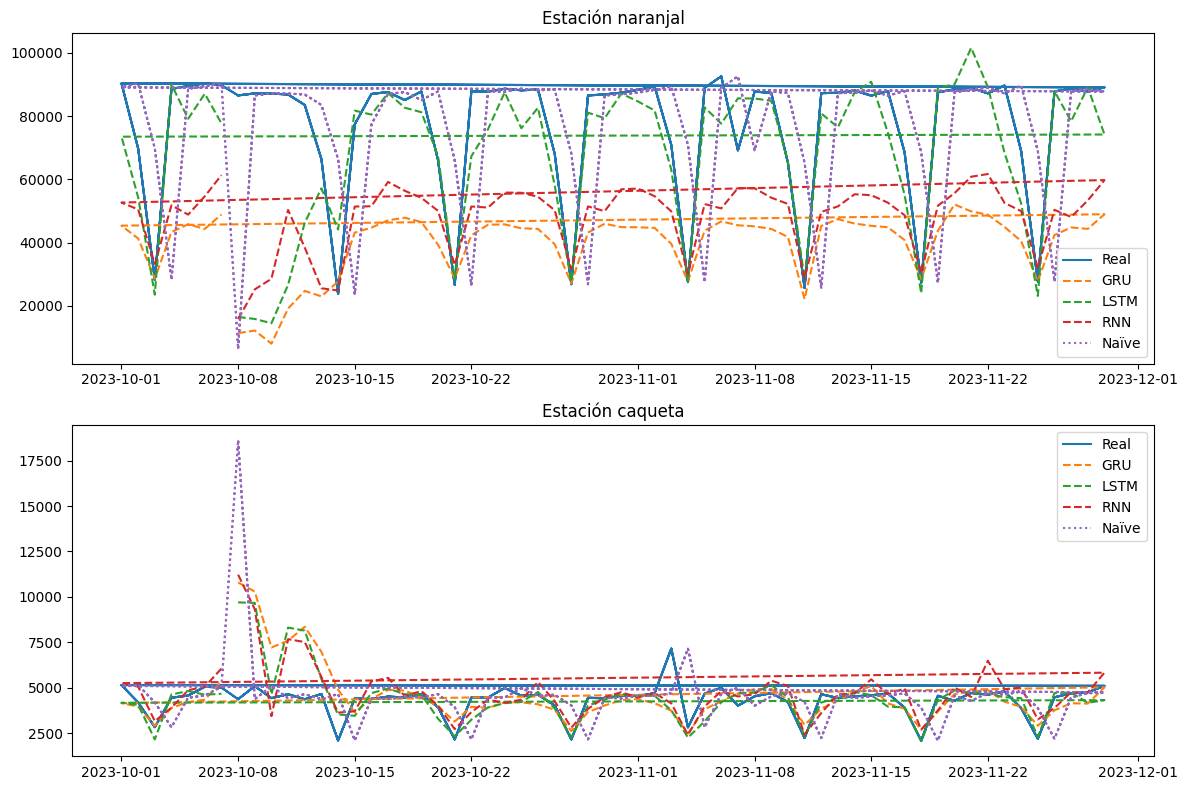

In [7]:
# ================================
# 9) Evaluación de modelos
# ================================
# --- Crea ds_test (igual que ds_train y ds_val) ---
ds_test = make_dataset(test_x, test_sid, test_eid, test_y, shuffle=False)

results = []
diag_dfs = []

def eval_model(name, model):
    pred_log = model.predict(ds_test)
    y_pred = np.expm1(scaler_tgt.inverse_transform(pred_log).flatten())
    y_true = test_df['target'].values[n_lags:]
    y_naive = pd.Series(y_true).shift(1).bfill().values

    results.append({
        "Modelo": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred)*100,
        "SMAPE (%)": smape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MASE": mase(y_true, y_pred, y_naive)
    })

    dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
    dfw["fecha"] = fechas_test.iloc[n_lags:].reset_index(drop=True)
    dfw["y_true"] = y_true
    dfw["y_pred"] = y_pred
    dfw["y_naive"] = y_naive

    sid_series = pd.Series(test_sid[n_lags:])
    dfw["estacion"] = sid_series.map({v: k for k, v in station_ids.items()}).values
    dfw["Modelo"] = name
    diag_dfs.append(dfw)

for name, mdl in models:
    eval_model(name, mdl)

# Baseline Naïve
ya = test_df['target'].values[n_lags:]
yn = pd.Series(ya).shift(1).bfill().values
results.append({
    "Modelo": "Naïve",
    "MAE": np.mean(np.abs(ya - yn)),
    "RMSE": np.nan,
    "MAPE (%)": np.nan,
    "SMAPE (%)": np.nan,
    "R2": np.nan,
    "MASE": np.nan
})

metrics_df = pd.DataFrame(results).sort_values("MAPE (%)")
print(metrics_df)

# ================================
# 10) Gráficos de comparación
# ================================
plt.figure(figsize=(12, 8))
for i, est in enumerate(["naranjal", "caqueta"], 1):
    sub = pd.concat(diag_dfs).query("estacion == @est")
    plt.subplot(2, 1, i)
    plt.plot(sub["fecha"], sub["y_true"], label="Real")
    for mod in sub["Modelo"].unique():
        plt.plot(
            sub.query("Modelo == @mod")["fecha"],
            sub.query("Modelo == @mod")["y_pred"], "--", label=mod
        )
    plt.plot(sub["fecha"], sub["y_naive"], ":", label="Naïve")
    plt.title(f'Estación {est}')
    plt.legend()
plt.tight_layout()
plt.show()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


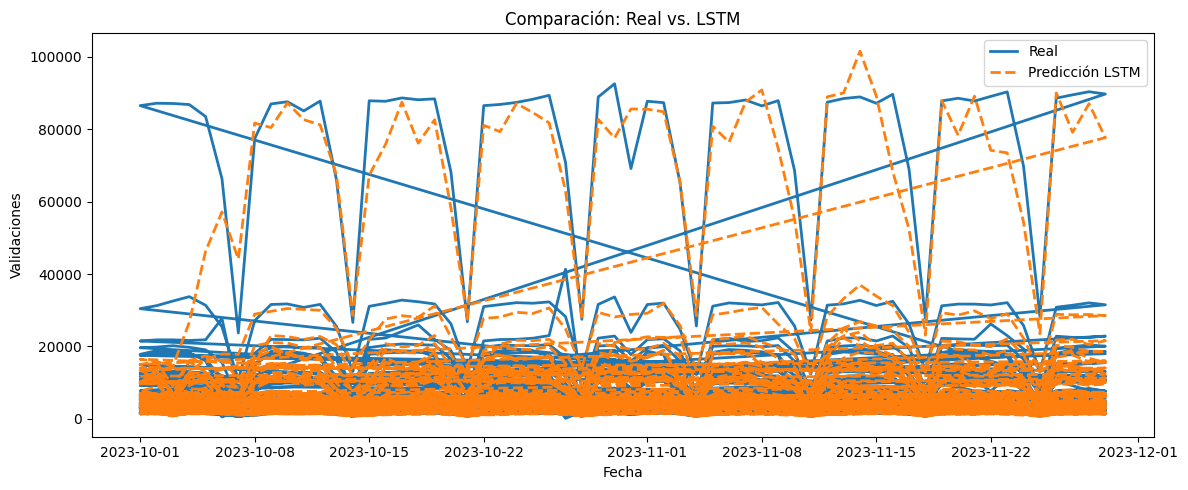

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Recupera tu modelo LSTM de la lista `models`
lstm_model = next(m for name, m in models if name == "LSTM")

# 2) Genera la predicción sobre el dataset de test
pred_log = lstm_model.predict(ds_test)
# Desescalamos y aplicamos expm1 para volver al espacio original
y_pred = np.expm1(scaler_tgt.inverse_transform(pred_log).flatten())

# 3) Extrae la serie real y las fechas correspondientes
y_true = test_df['target'].values[n_lags:]
fechas = fechas_test.iloc[n_lags:].reset_index(drop=True)

# 4) Grafica
plt.figure(figsize=(12, 5))
plt.plot(fechas, y_true, label="Real", linewidth=2)
plt.plot(fechas, y_pred, label="Predicción LSTM", linestyle='--', linewidth=2)
plt.title("Comparación: Real vs. LSTM")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.legend()
plt.tight_layout()
plt.show()


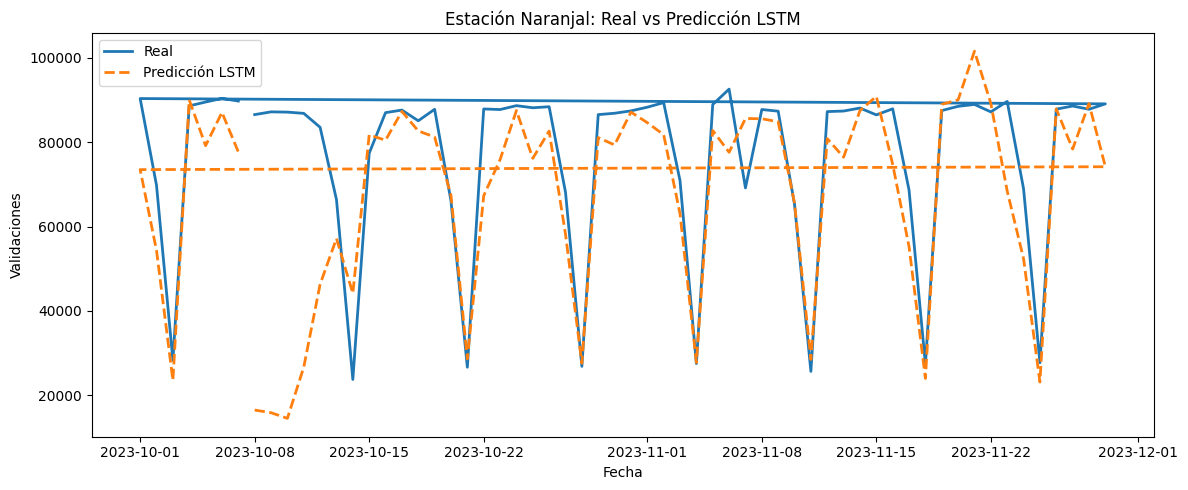

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Combina todos los dataframes de diagnóstico
df_all = pd.concat(diag_dfs, ignore_index=True)

# 2) Filtra únicamente la estación "naranjal" y el modelo LSTM
df_naranjal = df_all[
    (df_all["estacion"] == "naranjal") &
    (df_all["Modelo"]   == "LSTM")
].copy()

# 3) Extrae fechas, reales y predicciones
fechas   = df_naranjal["fecha"]
y_true   = df_naranjal["y_true"]
y_pred_l = df_naranjal["y_pred"]

# 4) Grafica
plt.figure(figsize=(12,5))
plt.plot(fechas, y_true,   label="Real",           linewidth=2)
plt.plot(fechas, y_pred_l, label="Predicción LSTM", linestyle="--", linewidth=2)
plt.title("Estación Naranjal: Real vs Predicción LSTM")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.legend()
plt.tight_layout()
plt.show()


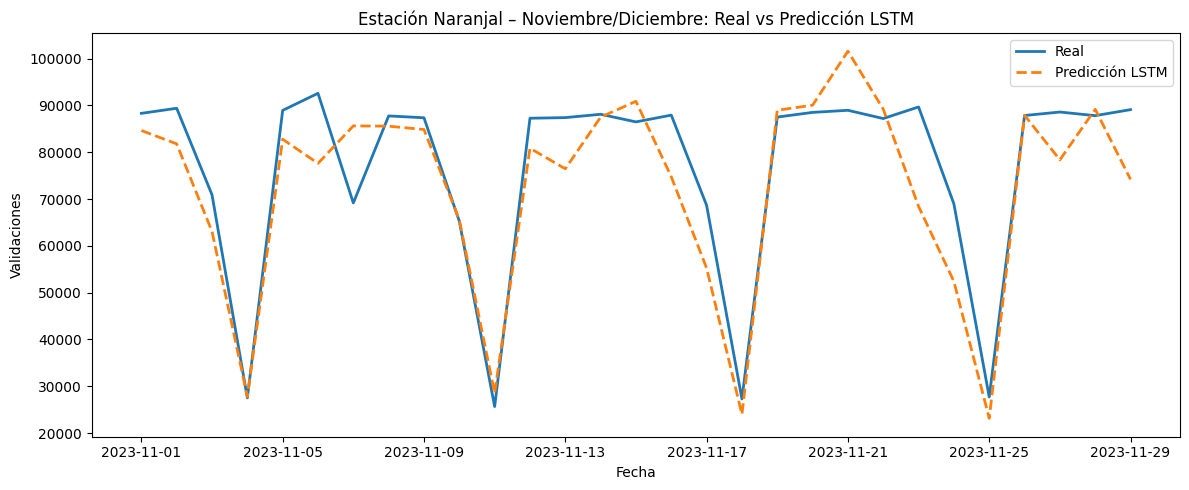

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Concatena diagnósticos de todos los modelos
df_all = pd.concat(diag_dfs, ignore_index=True)

# 2) Asegúrate de que la columna 'fecha' sea datetime
df_all['fecha'] = pd.to_datetime(df_all['fecha'])

# 3) Filtra solo Naranjal, LSTM y meses 11 y 12
mask = (
    (df_all['estacion'] == 'naranjal') &
    (df_all['Modelo']   == 'LSTM')     &
    (df_all['fecha'].dt.month.isin([11, 12]))
)
df_nov_dic = df_all.loc[mask].copy()

# 4) Extrae las series
fechas = df_nov_dic['fecha']
y_true = df_nov_dic['y_true']
y_pred = df_nov_dic['y_pred']

# 5) Grafica
plt.figure(figsize=(12, 5))
plt.plot(fechas, y_true, label="Real", linewidth=2)
plt.plot(fechas, y_pred, label="Predicción LSTM", linestyle='--', linewidth=2)
plt.title("Estación Naranjal – Noviembre/Diciembre: Real vs Predicción LSTM")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.legend()
plt.tight_layout()
plt.show()


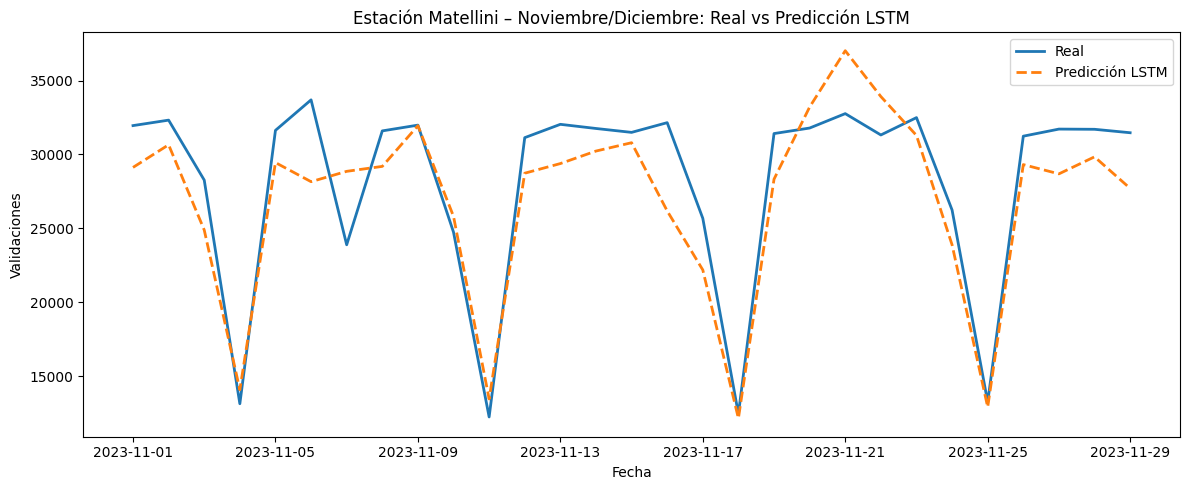

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Concatena diagnósticos de todos los modelos
df_all = pd.concat(diag_dfs, ignore_index=True)

# 2) Asegúrate de que la columna 'fecha' sea datetime
df_all['fecha'] = pd.to_datetime(df_all['fecha'])

# 3) Filtra solo Matellini, LSTM y meses 11 y 12
mask = (
    (df_all['estacion'] == 'matellini') &
    (df_all['Modelo']   == 'LSTM')     &
    (df_all['fecha'].dt.month.isin([11, 12]))
)
df_nov_dic = df_all.loc[mask].copy()

# 4) Extrae las series
fechas = df_nov_dic['fecha']
y_true = df_nov_dic['y_true']
y_pred = df_nov_dic['y_pred']

# 5) Grafica
plt.figure(figsize=(12, 5))
plt.plot(fechas, y_true, label="Real", linewidth=2)
plt.plot(fechas, y_pred, label="Predicción LSTM", linestyle='--', linewidth=2)
plt.title("Estación Matellini – Noviembre/Diciembre: Real vs Predicción LSTM")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.legend()
plt.tight_layout()
plt.show()


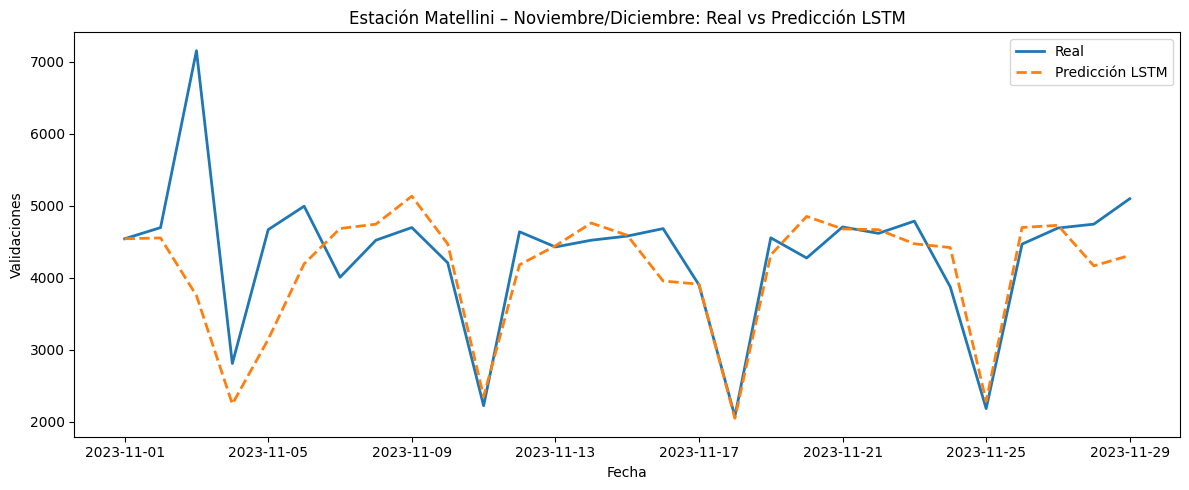

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Concatena diagnósticos de todos los modelos
df_all = pd.concat(diag_dfs, ignore_index=True)

# 2) Asegúrate de que la columna 'fecha' sea datetime
df_all['fecha'] = pd.to_datetime(df_all['fecha'])

# 3) Filtra solo Matellini, LSTM y meses 11 y 12
mask = (
    (df_all['estacion'] == 'caqueta') &
    (df_all['Modelo']   == 'LSTM')     &
    (df_all['fecha'].dt.month.isin([11, 12]))
)
df_nov_dic = df_all.loc[mask].copy()

# 4) Extrae las series
fechas = df_nov_dic['fecha']
y_true = df_nov_dic['y_true']
y_pred = df_nov_dic['y_pred']

# 5) Grafica
plt.figure(figsize=(12, 5))
plt.plot(fechas, y_true, label="Real", linewidth=2)
plt.plot(fechas, y_pred, label="Predicción LSTM", linestyle='--', linewidth=2)
plt.title("Estación Matellini – Noviembre/Diciembre: Real vs Predicción LSTM")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# Funciones SMAPE y MASE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) /
                   (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def mase(y_true, y_pred, y_naive):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    return mae_model / (mae_naive + 1e-8)

# 1) Concatena todos los diag_dfs
df_all = pd.concat(diag_dfs, ignore_index=True)

# 2) Lista de estaciones
stations = df_all['estacion'].unique()

# 3) Recorre cada estación y calcula métricas
metrics = []
for est in stations:
    sub = df_all[df_all['estacion'] == est].copy()
    y_true = sub['y_true'].values
    y_pred = sub['y_pred'].values
    # Naïve (valor día anterior)
    y_naive = pd.Series(y_true).shift(1).bfill().values

    metrics.append({
        'Estación': est,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred)*100,
        'SMAPE (%)': smape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MASE': mase(y_true, y_pred, y_naive)
    })

# 4) DataFrame resumen
metr_df = pd.DataFrame(metrics).sort_values('MAE')
print(metr_df.to_string(index=False))


          Estación          MAE         RMSE  MAPE (%)  SMAPE (%)         R2     MASE
parque del trabajo   227.895911   284.256859 15.407807  15.578339   0.426903 0.636430
   escuela militar   232.010253   314.184289 15.560535  16.565964   0.056344 0.864944
        el milagro   297.480021   368.037967 15.782045  15.607458   0.480311 0.656143
      los jazmines   334.864835   664.835699 22.617164  17.389306  -3.138214 1.131943
             teran   359.631597   503.636435 14.091390  13.424117   0.172641 0.710066
     estadio union   395.609169   557.329253 16.693122  15.508739  -0.097129 0.798285
  rosario de villa   475.534964   781.005167 16.143378  14.459214  -1.041252 0.901154
             balta   490.840363   636.134151 11.380812  11.457006   0.186313 0.757873
       28 de julio   527.498745   666.823241 16.114229  16.330372   0.474636 0.668872
            quilca   529.931278   710.545321 23.458525  19.448093   0.341547 0.693283
      domingo orue   540.147456   659.454717 22.138542

In [17]:
import numpy as np
from sklearn.metrics import r2_score

# 1) Filtrar solo Naranjal y meses 11/12
df_all = pd.concat(diag_dfs, ignore_index=True)
mask = (
    (df_all['estacion']=="naranjal") &
    (df_all['fecha'].dt.month.isin([11,12])) &
    (df_all['Modelo']=="LSTM")
)
sub = df_all[mask]

# 2) Extraer verdaderos y predicciones
y_true = sub['y_true'].values
y_pred = sub['y_pred'].values

# 3) Calcular R2 en ese periodo
r2_nov_dic = r2_score(y_true, y_pred)
print("R² Naranjal (Nov-Dic):", r2_nov_dic)


R² Naranjal (Nov-Dic): 0.8089918197711885


In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# Funciones SMAPE y MASE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) /
                   (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def mase(y_true, y_pred, y_naive):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    return mae_model / (mae_naive + 1e-8)

# 1) Concatena todos los diag_dfs
df_all = pd.concat(diag_dfs, ignore_index=True)
df_all['fecha'] = pd.to_datetime(df_all['fecha'])  # por si acaso

# 2) Lista de estaciones
stations = df_all['estacion'].unique()

metrics = []
for est in stations:
    # 3a) Filtra la estación, el modelo LSTM y meses 11 y 12
    sub = df_all[
        (df_all['estacion'] == est) &
        (df_all['Modelo']   == 'LSTM') &
        (df_all['fecha'].dt.month.isin([11, 12]))
    ].copy()
    if len(sub) < 2:
        # Saltar estaciones sin suficientes datos
        continue

    y_true  = sub['y_true'].values
    y_pred  = sub['y_pred'].values
    # Naïve: valor del día anterior en este tramo
    y_naive = pd.Series(y_true).shift(1).bfill().values

    metrics.append({
        'Estación': est,
        'MAE':     mean_absolute_error(y_true, y_pred),
        'RMSE':    np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred)*100,
        'SMAPE (%)': smape(y_true, y_pred),
        'R2':      r2_score(y_true, y_pred),
        'MASE':    mase(y_true, y_pred, y_naive)
    })

# 4) DataFrame resumen ordenado
metr_df = pd.DataFrame(metrics).sort_values('MAE')
print(metr_df.to_string(index=False))


          Estación         MAE        RMSE   MAPE (%)  SMAPE (%)        R2     MASE
      los jazmines  150.057185  195.728057   8.765232   9.308375  0.647246 0.471022
          pacifico  190.310207  234.535805  12.401397  13.399084  0.488206 0.573256
parque del trabajo  208.998672  263.497821  12.324436  13.299034  0.506198 0.554909
        el milagro  226.558663  293.289069  10.849107  11.372726  0.667193 0.465545
   escuela militar  232.674820  273.787155  15.585535  17.318133 -0.030547 0.841118
             teran  263.615863  336.121928   8.980983   9.602323  0.494484 0.577282
     estadio union  267.480948  345.387718  10.510566  11.110997  0.613000 0.494992
  rosario de villa  277.619118  365.405673   8.891112   9.490982  0.548543 0.490772
      domingo orue  315.360465  420.884449  11.441951  12.071364  0.708352 0.458066
   honorio delgado  334.676879  443.255180  12.927610  13.322845  0.677335 0.439940
            quilca  345.129104  495.162656  16.373298  13.062182  0.711232 0